# Importing Libraries

In [3]:
#Loading & importing necessary packages
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, accuracy_score, fbeta_score, precision_score, recall_score, roc_auc_score, roc_curve,precision_recall_curve
from sklearn.utils import resample, shuffle
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.inspection import plot_partial_dependence
from sklearn.feature_selection import RFE

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline
from time import time

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [4]:
# import session_info
# session_info.show()

In [2]:
#Load the data
df = pd.read_csv('loan_data.csv')
df.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [3]:
#Analysing & understanding the data attributes
print("Number of Rows:"+ str(df.shape[0]))
print("Number of Columns:"+ str(df.shape[1]))
df.info()

Number of Rows:9578
Number of Columns:14
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


In [4]:
#Replacing dots in column names with underscore
df.columns = df.columns.str.replace('.','_')
df.head()

,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


#  Creating Data dictionary

In [5]:
#Creating a data dictionary for loan data attributes
data_dict = pd.DataFrame(columns=['Attributes', 'No.of unique values'])

for i, j in enumerate(df.columns):
    data_dict.loc[i] = [j, df[j].nunique()]
    
attr_df = pd.read_csv('attribute _details.csv')        #Reading new csv file that contains details to individual attributes

data_dict = data_dict.join(attr_df['Attribute Details'])
pd.options.display.max_colwidth = 200
data_dict

,Attributes,No.of unique values,Attribute Details
0,credit_policy,2,"if the customer meets the credit underwriting criteria of LendingClub.com, and 0 otherwise."
1,purpose,7,"The purpose of the loan (takes values ""credit_card"", ""debt_consolidation"", ""educational"", ""major_purchase"", ""small_business"", and ""all_other"")."
2,int_rate,249,"The interest rate of the loan, as a proportion (a rate of 11% would be stored as 0.11). Borrowers judged by LendingClub.com to be more risky are assigned higher interest rates."
3,installment,4788,The monthly installments owed by the borrower if the loan is funded.
4,log_annual_inc,1987,The natural log of the self-reported annual income of the borrower.
5,dti,2529,The debt-to-income ratio of the borrower (amount of debt divided by annual income).
6,fico,44,The FICO credit score of the borrower.
7,days_with_cr_line,2687,The number of days the borrower has had a credit line.
8,revol_bal,7869,The borrower's revolving balance (amount unpaid at the end of the credit card billing cycle).
9,revol_util,1035,The borrower's revolving line utilization rate (the amount of the credit line used relative to total credit available).


In [6]:
#Spliting columns based on data type
nums = data_dict.Attributes.tolist()
nums.pop(1)
nums.pop()                        #Eliminating not_fully_paid to avoid training errors
strs = ['purpose']
type(nums)
nums

['credit_policy',
 'int_rate',
 'installment',
 'log_annual_inc',
 'dti',
 'fico',
 'days_with_cr_line',
 'revol_bal',
 'revol_util',
 'inq_last_6mths',
 'delinq_2yrs',
 'pub_rec']

In [7]:
# plt.figure(figsize=(14,13))
# plt.title('Data Correlation')
# sns.heatmap(df.corr(), annot=True, fmt='.1f', cmap="YlGnBu")       # linewidths=.5

In [8]:
#Investigating the chances of null or missing data.
df.isnull().sum()

credit_policy        0
purpose              0
int_rate             0
installment          0
log_annual_inc       0
dti                  0
fico                 0
days_with_cr_line    0
revol_bal            0
revol_util           0
inq_last_6mths       0
delinq_2yrs          0
pub_rec              0
not_fully_paid       0
dtype: int64

# Train & Test splitting

In [9]:
#Creating train,test,validation splits
    train, test = train_test_split(df, test_size=0.25, random_state=42)
train, valid = train_test_split(df, test_size=0.25, random_state=42)
print(valid.shape)
print(train.shape)
valid.head()

(2395, 14)
(7183, 14)


,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid
8558,0,debt_consolidation,0.1545,453.52,10.596635,14.52,657,3810.000000,8545,82.2,3,0,0,0
4629,1,debt_consolidation,0.1183,533.46,11.156251,10.89,732,3600.000000,15942,40.9,3,0,0,0
1383,1,credit_card,0.1146,197.75,10.348173,13.73,692,2069.958333,14154,85.8,0,0,0,1
8142,0,all_other,0.1646,106.16,11.002100,28.16,672,6480.041667,7846,25.8,4,1,0,0
1768,1,all_other,0.1221,159.92,11.127322,3.99,702,5040.000000,468,7.2,1,1,0,0


## Creating training split

In [10]:
#Creating X & Y splits for training set
X_train = train.drop('not_fully_paid', axis=1)
Y_train = train['not_fully_paid']
print(X_train.shape)
X_train.head()

(7183, 13)


,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec
2058,1,debt_consolidation,0.1568,310.64,10.279318,19.53,692,3738.000000,21894,99.5,0,0,0
9316,0,home_improvement,0.1183,256.79,10.736310,13.31,722,4560.000000,7562,57.7,4,0,0
5411,1,credit_card,0.0894,413.03,10.861458,18.99,747,3209.958333,14385,50.3,1,0,0
1166,1,educational,0.1355,232.63,11.156251,24.22,687,3749.958333,8547,55.1,1,1,0
8329,0,debt_consolidation,0.1450,137.69,10.566072,22.05,657,3269.000000,8623,71.0,3,0,0


## Creating testing split

In [11]:
#Creating X & Y splits for testing set
X_test = test.drop('not_fully_paid', axis=1)
Y_test = test[['not_fully_paid']]
print(X_test.shape)
print(Y_test.shape)
Y_test.head()

(2395, 13)
(2395, 1)


,not_fully_paid
8558,0
4629,0
1383,1
8142,0
1768,0


## Creating validation split

In [12]:
#Creating X & Y splits for validation set
X_valid = valid.drop('not_fully_paid', axis=1)
Y_valid = valid[['not_fully_paid']]
print(X_valid.shape)
print(Y_valid.shape)
Y_valid.head()

(2395, 13)
(2395, 1)


,not_fully_paid
8558,0
4629,0
1383,1
8142,0
1768,0


# Exploratory Data Analysis

In [13]:
X_train[['purpose']].describe()

,purpose
count,7183
unique,7
top,debt_consolidation
freq,2963


Based on the initial train split, we can see that majority of the clients has taken loan's based on 'debt_consolidation'. Let's see the total distibution of purpose categories.

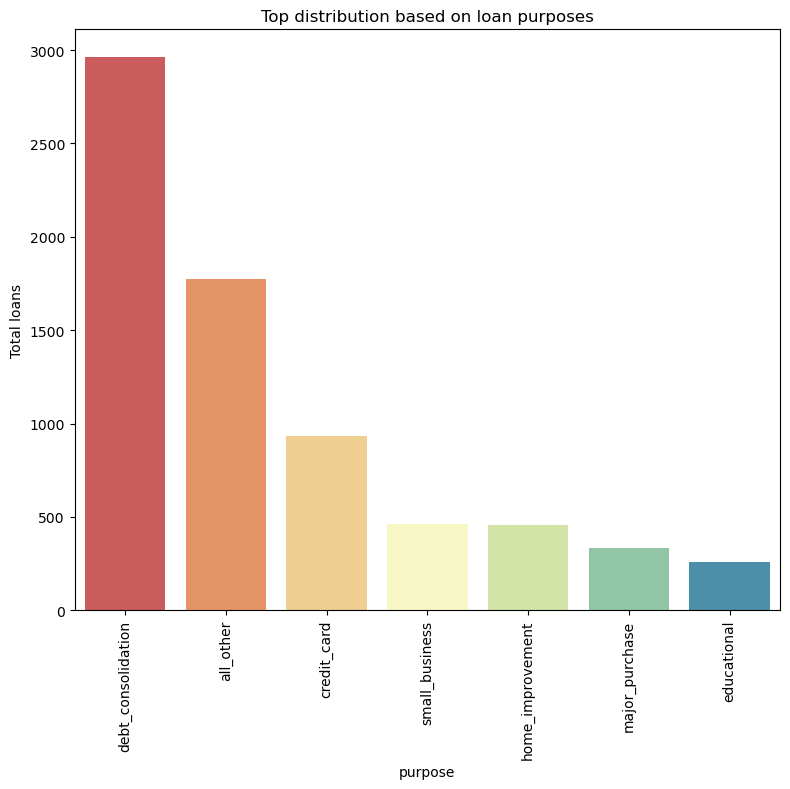

In [14]:
#Checking the main purpose of loans based different categories
plt.figure(figsize=(8,8), dpi=100)

for i, j in enumerate(['purpose']):
    main_order = train[j].value_counts().index                #     main_order = train[j].nunique()
    plt.subplot(1,1,i+1)
    sns.countplot(train[j], order = main_order, palette='Spectral')
#     sns.color_palette('coolwarm')
    plt.title('Top distribution based on loan purposes')
    plt.ylabel('Total loans')
    plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Based on above distribution, it is clear that debt_consolidation has the high proportion of the loan purpose, where education was the least purpose for a loan. Since the distribution around these are highly imbalanced, it is more likely that we need to work on hypothesis or find some evidence.

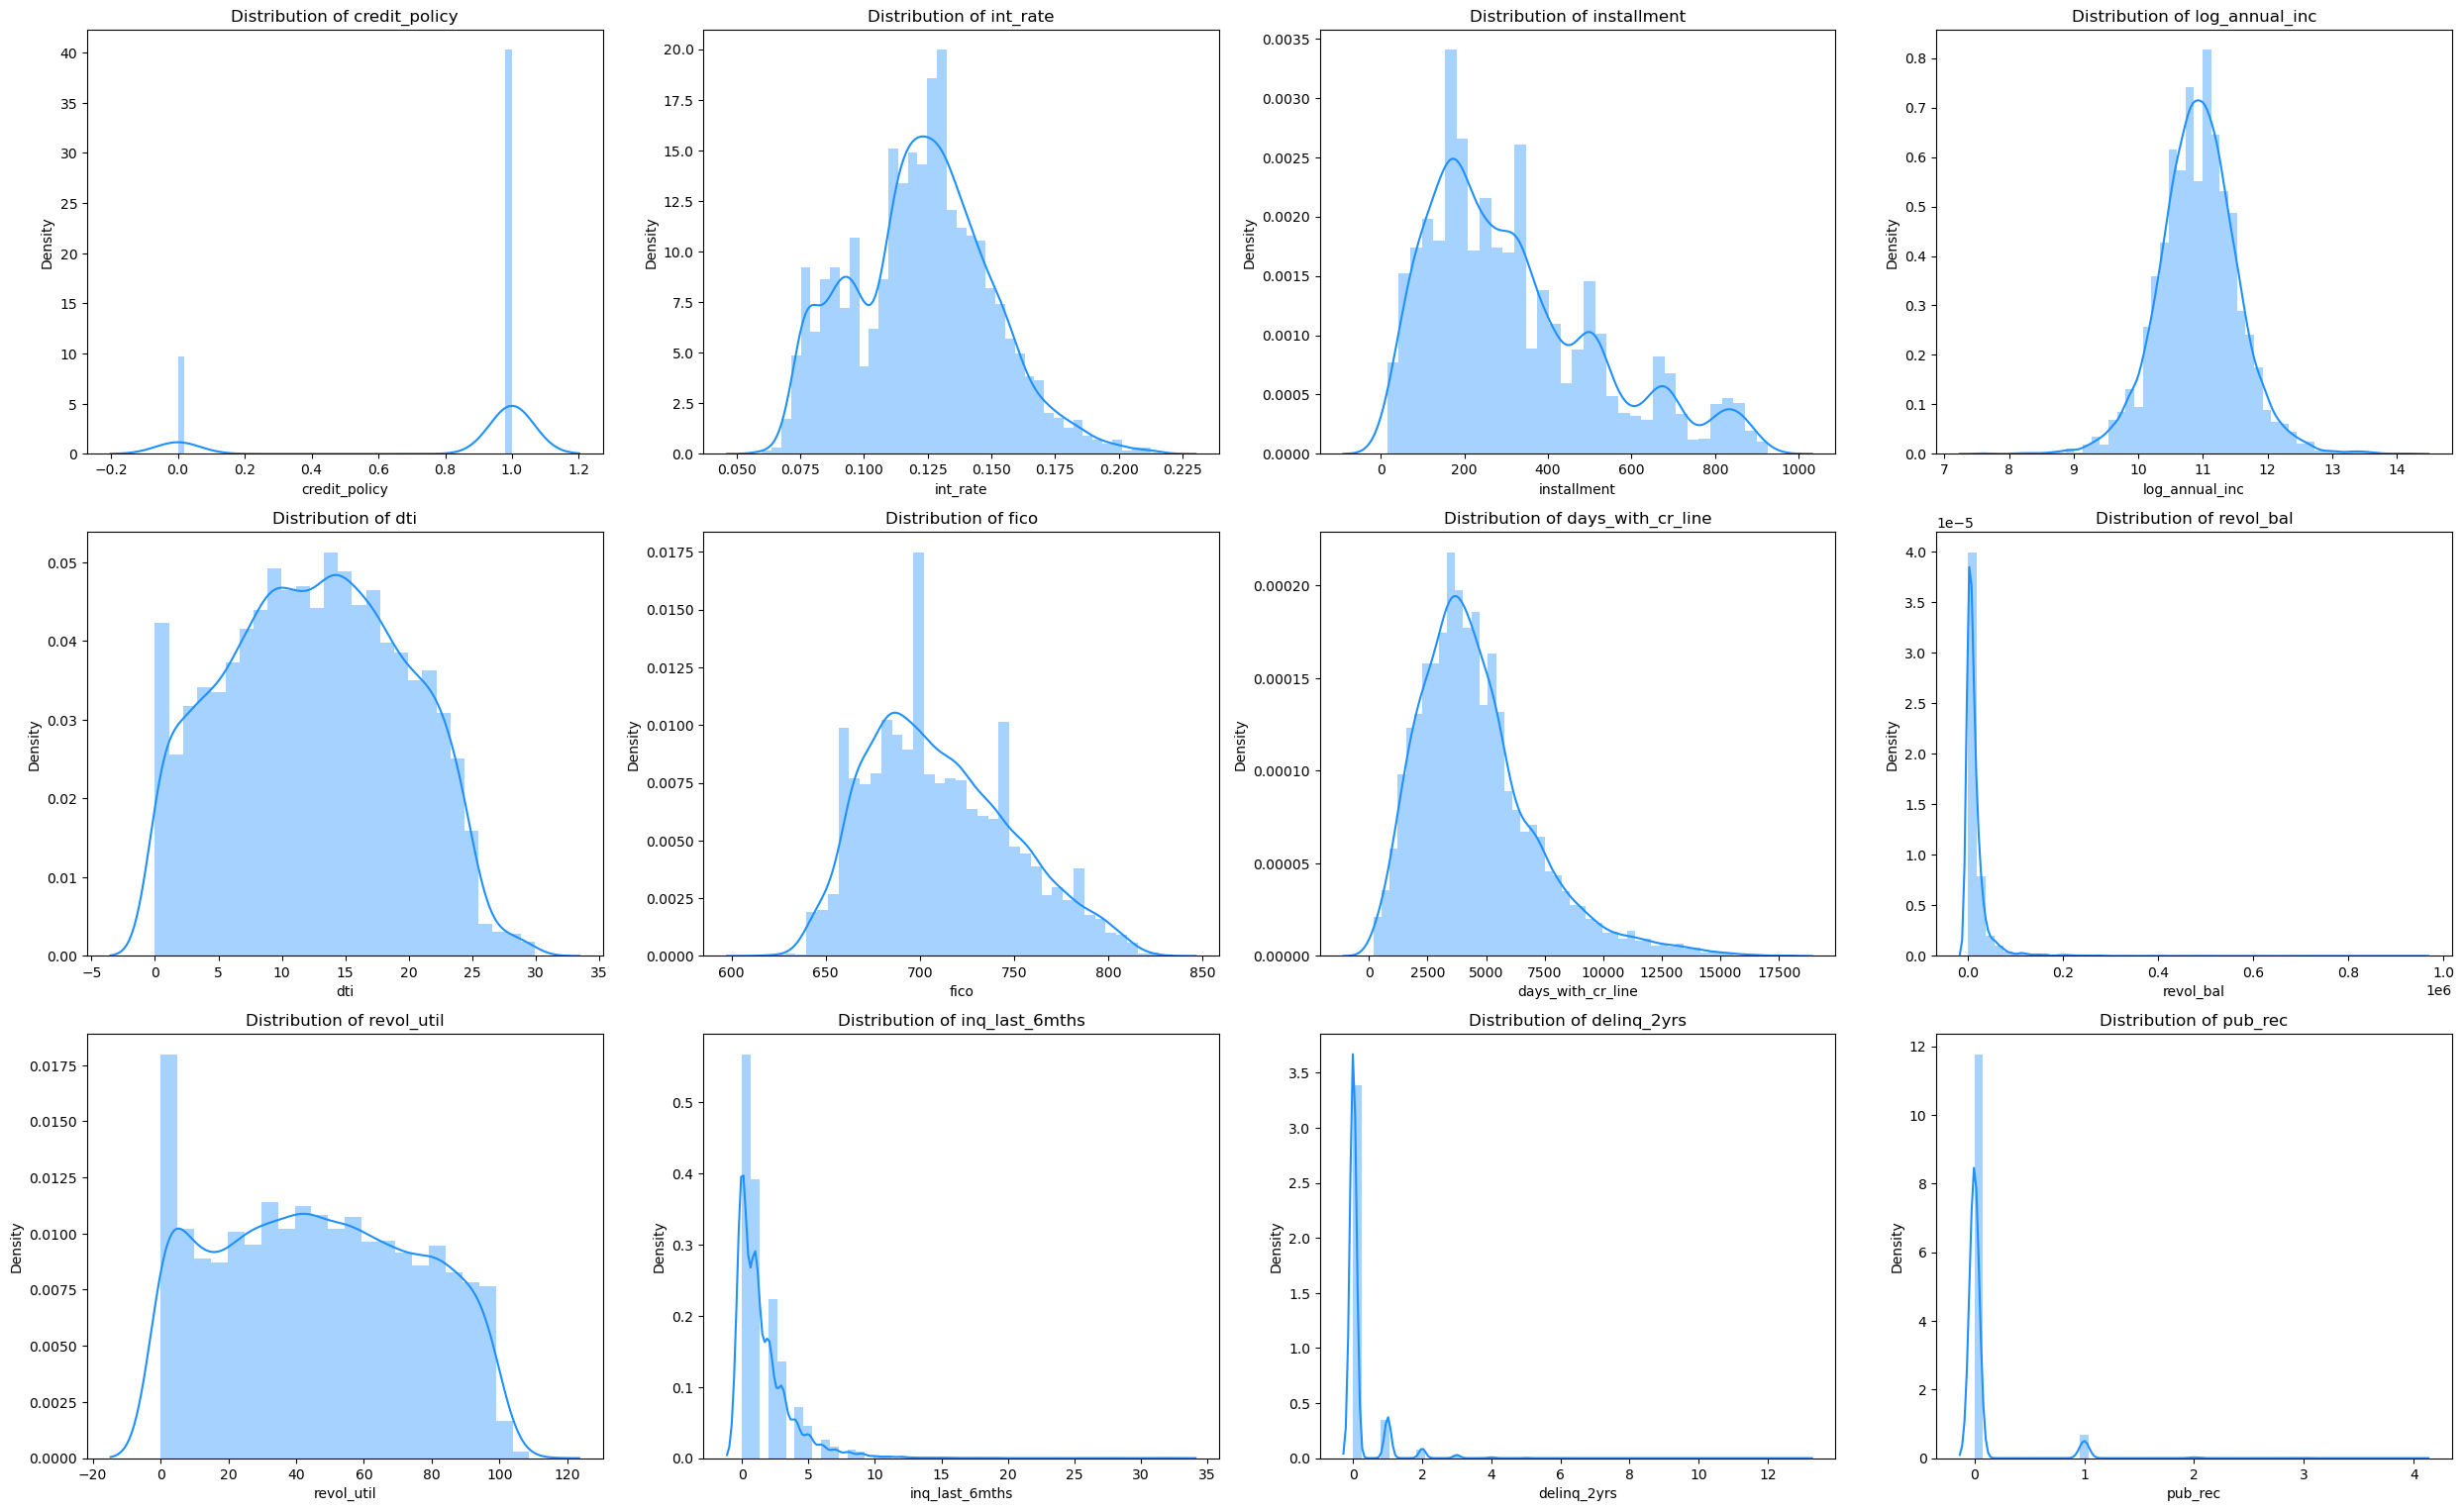

In [15]:
#Checking the skew-distribution among different variables
plt.figure(figsize=(25,20),dpi=100)
           
for i,j in enumerate(nums):
    plt.subplot(4,4,i+1)
    sns.distplot(X_train[j], color='dodgerblue')
    plt.title('Distribution of '+str(j))
plt.tight_layout()
plt.show()

# plt.xlim(50,75)    #X-axis scale ranging

For the above distribution, it is clear that all the attributes are highly-skewed.(Except log_annual_inc, because the data is transformed into base log). By transforming rest of the data to 'log values' we can reduce the modelling errors during ML training.

In [16]:
#Creating a funtion for log transformation
def log_trans(data, temp):
    data = data.copy()
    for i in temp:
        data[i] = np.log(1+data[i])
    return data
    

In [17]:
df['purpose'].unique()
nums


['credit_policy',
 'int_rate',
 'installment',
 'log_annual_inc',
 'dti',
 'fico',
 'days_with_cr_line',
 'revol_bal',
 'revol_util',
 'inq_last_6mths',
 'delinq_2yrs',
 'pub_rec']

In [18]:
temp_nums = nums.copy()
temp_nums.pop(3)
temp_nums

['credit_policy',
 'int_rate',
 'installment',
 'dti',
 'fico',
 'days_with_cr_line',
 'revol_bal',
 'revol_util',
 'inq_last_6mths',
 'delinq_2yrs',
 'pub_rec']

In [19]:
nums

['credit_policy',
 'int_rate',
 'installment',
 'log_annual_inc',
 'dti',
 'fico',
 'days_with_cr_line',
 'revol_bal',
 'revol_util',
 'inq_last_6mths',
 'delinq_2yrs',
 'pub_rec']

In [20]:
#Before applying log transform to data, we need to convert the purpose columns to numerical data
X_train_log = pd.get_dummies(data=X_train)
X_train_log = X_train_log.drop(['purpose_all_other'],axis=1)
X_test_log = pd.get_dummies(data=X_test)
X_test_log = X_test_log.drop(['purpose_all_other'],axis=1)
X_valid_log = pd.get_dummies(data=X_valid)
X_valid_log = X_valid_log.drop(['purpose_all_other'],axis=1)

#Transform
X_train_log_t = log_trans(X_train_log, temp_nums)
X_test_log_t = log_trans(X_test_log, temp_nums)
X_valid_log_t = log_trans(X_valid_log, temp_nums)
X_valid_log_t.head()

,credit_policy,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
8558,0.000000,0.143667,6.119242,10.596635,2.742130,6.489205,8.245647,9.053219,4.421247,1.386294,0.000000,0.0,0,1,0,0,0,0
4629,0.693147,0.111810,6.281257,11.156251,2.475698,6.597146,8.188967,9.676775,3.735286,1.386294,0.000000,0.0,0,1,0,0,0,0
1383,0.693147,0.108496,5.292048,10.348173,2.689886,6.541030,7.635767,9.557823,4.463607,0.000000,0.000000,0.0,1,0,0,0,0,0
8142,0.000000,0.152378,4.674323,11.002100,3.372798,6.511745,8.776637,8.967887,3.288402,1.609438,0.693147,0.0,0,0,0,0,0,0
1768,0.693147,0.115202,5.080907,11.127322,1.607436,6.555357,8.525360,6.150603,2.104134,0.693147,0.693147,0.0,0,0,0,0,0,0


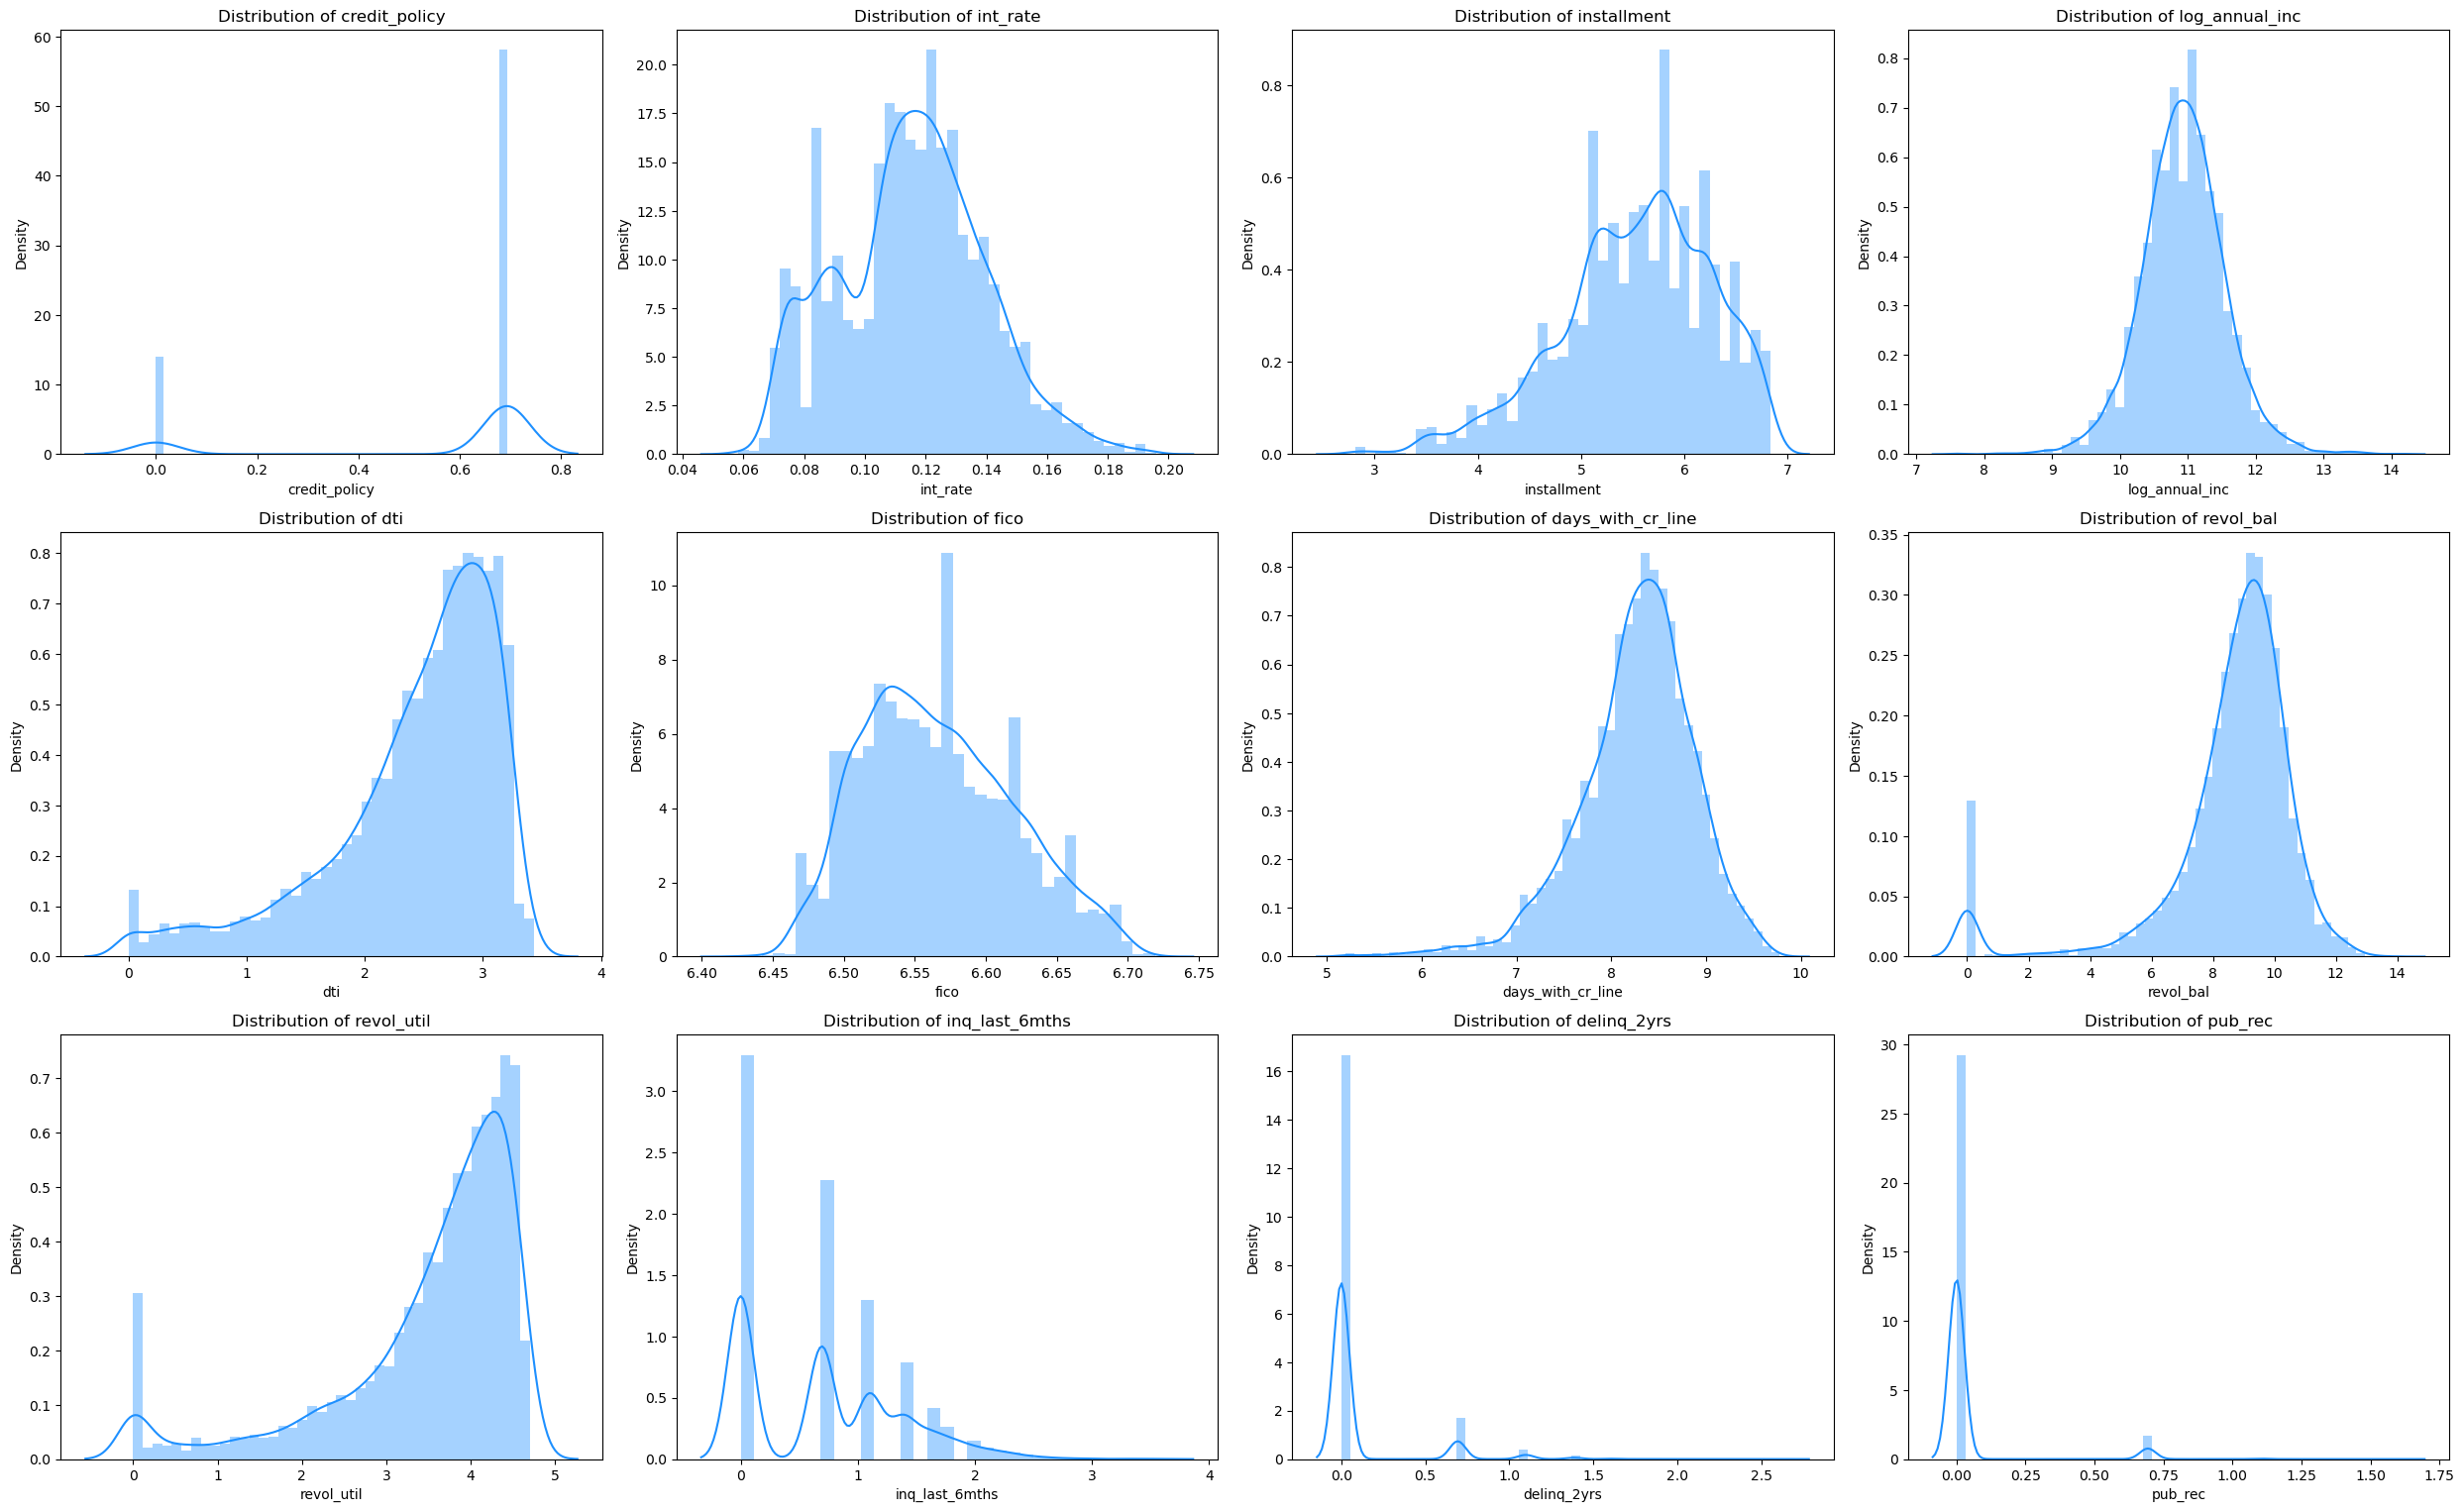

In [21]:
#Checking skew-distribution after log transformation

plt.figure(figsize=(25,20),dpi=100)
           
for i,j in enumerate(nums):
    plt.subplot(4,4,i+1)
    sns.distplot(X_train_log_t[j], color='dodgerblue')
    plt.title('Distribution of '+str(j))
plt.tight_layout()
plt.show()

For now, the values are transformed to log - the distribution has improved compared to data before log transfom. But still the data needs to be normalised, because log_income_inc, installments are highly scaled.
So, it is recommended to use scaler techniques to drop down the values. In this case, I'm using standard scaler.

In [22]:
# Using standard scaler
scaler = StandardScaler()
scaler.fit(X_train_log_t)

#Transform
temp_X_train_log = scaler.transform(X_train_log_t)
temp_X_test_log = scaler.transform(X_test_log_t)
temp_X_valid_log = scaler.transform(X_valid_log_t)

# type(X_valid_log)

X_train_log_nw = pd.DataFrame(data=temp_X_train_log, index=X_train_log.index, columns=X_train_log.columns)
X_test_log_nw = pd.DataFrame(data=temp_X_test_log, index=X_test_log.index, columns=X_test_log.columns)
X_valid_log_nw = pd.DataFrame(data=temp_X_valid_log, index=X_valid_log.index, columns=X_valid_log.columns)

X_train_log_nw.describe()

,credit_policy,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
count,7.183000e+03,7.183000e+03,7.183000e+03,7.183000e+03,7.183000e+03,7.183000e+03,7.183000e+03,7.183000e+03,7.183000e+03,7.183000e+03,7.183000e+03,7.183000e+03,7.183000e+03,7.183000e+03,7.183000e+03,7.183000e+03,7.183000e+03,7.183000e+03
mean,-6.771232e-16,-6.979737e-16,2.786377e-16,-4.735643e-16,-5.216642e-16,-4.467461e-15,9.195160e-16,-4.289421e-16,1.603123e-16,1.342560e-16,-6.572774e-16,-1.883283e-15,1.472162e-15,-1.943779e-16,3.175643e-16,4.529920e-16,9.738756e-16,2.587378e-16
std,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00,1.000070e+00
min,-2.033318e+00,-2.377794e+00,-3.711375e+00,-5.544775e+00,-3.336702e+00,-2.643760e+00,-5.092979e+00,-3.889380e+00,-3.137233e+00,-1.065766e+00,-3.491767e-01,-2.460354e-01,-3.868435e-01,-8.379336e-01,-1.930190e-01,-2.606632e-01,-2.211773e-01,-2.621827e-01
25%,4.918070e-01,-7.284401e-01,-5.845846e-01,-5.975408e-01,-4.274807e-01,-7.576804e-01,-5.360354e-01,-2.389435e-01,-3.077009e-01,-1.065766e+00,-3.491767e-01,-2.460354e-01,-3.868435e-01,-8.379336e-01,-1.930190e-01,-2.606632e-01,-2.211773e-01,-2.621827e-01
50%,4.918070e-01,-5.524760e-03,9.123931e-02,-1.274500e-02,2.759975e-01,-7.969283e-02,1.008783e-01,2.093130e-01,3.190831e-01,-2.276032e-02,-3.491767e-01,-2.460354e-01,-3.868435e-01,-8.379336e-01,-1.930190e-01,-2.606632e-01,-2.211773e-01,-2.621827e-01
75%,4.918070e-01,6.648836e-01,7.337597e-01,5.830314e-01,7.275346e-01,7.029749e-01,6.316922e-01,5.522918e-01,7.024776e-01,5.873591e-01,-3.491767e-01,-2.460354e-01,-3.868435e-01,1.193412e+00,-1.930190e-01,-2.606632e-01,-2.211773e-01,-2.621827e-01
max,4.918070e-01,3.356800e+00,1.777194e+00,5.315878e+00,1.405299e+00,2.873135e+00,2.505845e+00,2.343984e+00,1.085479e+00,4.240488e+00,8.887425e+00,9.181480e+00,2.585025e+00,1.193412e+00,5.180838e+00,3.836369e+00,4.521260e+00,3.814134e+00


In [23]:
X_train_log_nw.head()

,credit_policy,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
2058,0.491807,1.263492,0.287352,-1.071556,0.837799,-0.483554,-0.068562,0.635886,1.005941,-1.065766,-0.349177,-0.246035,-0.386843,1.193412,-0.193019,-0.260663,-0.221177,-0.262183
9316,-2.033318,-0.146872,0.028298,-0.323253,0.339204,0.315701,0.261201,0.154566,0.522691,1.356019,-0.349177,-0.246035,-0.386843,-0.837934,-0.193019,3.836369,-0.221177,-0.262183
5411,0.491807,-1.237841,0.675298,-0.118330,0.800977,0.956809,-0.321204,0.445710,0.401591,-0.022760,-0.349177,-0.246035,2.585025,-0.837934,-0.193019,-0.260663,-0.221177,-0.262183
1166,0.491807,0.489119,-0.106084,0.364380,1.122027,-0.620119,-0.063263,0.210002,0.481976,-0.022760,2.076812,-0.246035,-0.386843,-0.837934,5.180838,-0.260663,-0.221177,-0.262183
8329,-2.033318,0.836276,-0.818227,-0.602009,0.997738,-1.460953,-0.290969,0.214010,0.706230,1.020246,-0.349177,-0.246035,-0.386843,1.193412,-0.193019,-0.260663,-0.221177,-0.262183


In [24]:
X_test_log_nw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2395 entries, 8558 to 8216
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   credit_policy               2395 non-null   float64
 1   int_rate                    2395 non-null   float64
 2   installment                 2395 non-null   float64
 3   log_annual_inc              2395 non-null   float64
 4   dti                         2395 non-null   float64
 5   fico                        2395 non-null   float64
 6   days_with_cr_line           2395 non-null   float64
 7   revol_bal                   2395 non-null   float64
 8   revol_util                  2395 non-null   float64
 9   inq_last_6mths              2395 non-null   float64
 10  delinq_2yrs                 2395 non-null   float64
 11  pub_rec                     2395 non-null   float64
 12  purpose_credit_card         2395 non-null   float64
 13  purpose_debt_consolidation  23

In [25]:
X_valid_log_nw.head()

,credit_policy,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
8558,-2.033318,1.180564,0.802711,-0.551964,0.451336,-1.460953,-0.036911,0.209896,0.836166,1.020246,-0.349177,-0.246035,-0.386843,1.193412,-0.193019,-0.260663,-0.221177,-0.262183
4629,0.491807,-0.146872,1.023954,0.364380,0.083281,0.574765,-0.130966,0.492241,0.219689,1.020246,-0.349177,-0.246035,-0.386843,1.193412,-0.193019,-0.260663,-0.221177,-0.262183
1383,0.491807,-0.284962,-0.326885,-0.958808,0.379166,-0.483554,-1.048948,0.438380,0.874234,-1.065766,-0.349177,-0.246035,2.585025,-0.837934,-0.193019,-0.260663,-0.221177,-0.262183
8142,-2.033318,1.543504,-1.170434,0.111966,1.322555,-1.035850,0.844215,0.171258,-0.181928,1.356019,2.076812,-0.246035,-0.386843,-0.837934,-0.193019,-0.260663,-0.221177,-0.262183
1768,0.491807,-0.005525,-0.615213,0.317011,-1.116155,-0.213355,0.427245,-1.104401,-1.246236,-0.022760,2.076812,-0.246035,-0.386843,-0.837934,-0.193019,-0.260663,-0.221177,-0.262183


In [26]:
X_valid_log_nw.describe()

,credit_policy,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
count,2395.000000,2395.000000,2395.000000,2395.000000,2395.000000,2395.000000,2395.000000,2395.000000,2395.000000,2395.000000,2395.000000,2395.000000,2395.000000,2395.000000,2395.000000,2395.000000,2395.000000,2395.000000
mean,-0.002675,0.010531,0.024444,-0.010509,0.003027,-0.015936,-0.012312,0.041816,0.041889,-0.032121,-0.033894,-0.004025,0.018919,0.005138,-0.002298,0.033570,-0.019203,0.005033
std,1.002265,0.980338,0.986463,1.026605,0.991347,0.984507,1.009976,0.933958,0.959163,0.999581,0.952809,0.989537,1.020620,1.001109,0.994459,1.058007,0.957831,1.009097
min,-2.033318,-2.377794,-3.104922,-4.540990,-3.336702,-2.796966,-5.102938,-3.889380,-3.137233,-1.065766,-0.349177,-0.246035,-0.386843,-0.837934,-0.193019,-0.260663,-0.221177,-0.262183
25%,0.491807,-0.611475,-0.573099,-0.635955,-0.427481,-0.757680,-0.571710,-0.228012,-0.273641,-1.065766,-0.349177,-0.246035,-0.386843,-0.837934,-0.193019,-0.260663,-0.221177,-0.262183
50%,0.491807,0.024172,0.091239,-0.001007,0.273975,-0.079693,0.088846,0.220474,0.360367,-0.022760,-0.349177,-0.246035,-0.386843,-0.837934,-0.193019,-0.260663,-0.221177,-0.262183
75%,0.491807,0.694109,0.765494,0.623464,0.726441,0.702975,0.657405,0.557276,0.714925,0.587359,-0.349177,-0.246035,-0.386843,1.193412,-0.193019,-0.260663,-0.221177,-0.262183
max,0.491807,3.102539,1.796644,5.886040,1.395448,2.643975,2.379839,2.451574,1.165312,3.777804,5.921914,10.249454,2.585025,1.193412,5.180838,3.836369,4.521260,3.814134


In [27]:
#Creating a t-sne model to find the possible clusters

m_ts = TSNE(learning_rate=50)
df_tsne = Y_train.copy()

#By eliminating the columns that belongs to purpose, we're not giving any feature info to t-SNE model
X_train_num_log_nw = X_train_log_nw[nums]
X_train_num_log_nw.head()

,credit_policy,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec
2058,0.491807,1.263492,0.287352,-1.071556,0.837799,-0.483554,-0.068562,0.635886,1.005941,-1.065766,-0.349177,-0.246035
9316,-2.033318,-0.146872,0.028298,-0.323253,0.339204,0.315701,0.261201,0.154566,0.522691,1.356019,-0.349177,-0.246035
5411,0.491807,-1.237841,0.675298,-0.118330,0.800977,0.956809,-0.321204,0.445710,0.401591,-0.022760,-0.349177,-0.246035
1166,0.491807,0.489119,-0.106084,0.364380,1.122027,-0.620119,-0.063263,0.210002,0.481976,-0.022760,2.076812,-0.246035
8329,-2.033318,0.836276,-0.818227,-0.602009,0.997738,-1.460953,-0.290969,0.214010,0.706230,1.020246,-0.349177,-0.246035


In [28]:
tsne_feat = m_ts.fit_transform(X_train_num_log_nw)
print(tsne_feat.shape)

(7183, 2)


In [29]:
df_tsne = pd.concat([X_train,Y_train], axis=1)
df_tsne['tsne_feat_1'] = tsne_feat[:,0]
df_tsne['tsne_feat_2'] = tsne_feat[:,1]
df_tsne.head()


,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid,tsne_feat_1,tsne_feat_2
2058,1,debt_consolidation,0.1568,310.64,10.279318,19.53,692,3738.000000,21894,99.5,0,0,0,0,-25.300846,34.263405
9316,0,home_improvement,0.1183,256.79,10.736310,13.31,722,4560.000000,7562,57.7,4,0,0,1,-4.967795,-42.300571
5411,1,credit_card,0.0894,413.03,10.861458,18.99,747,3209.958333,14385,50.3,1,0,0,0,21.884827,7.823568
1166,1,educational,0.1355,232.63,11.156251,24.22,687,3749.958333,8547,55.1,1,1,0,0,42.955399,-21.069580
8329,0,debt_consolidation,0.1450,137.69,10.566072,22.05,657,3269.000000,8623,71.0,3,0,0,0,-15.662248,-38.827309


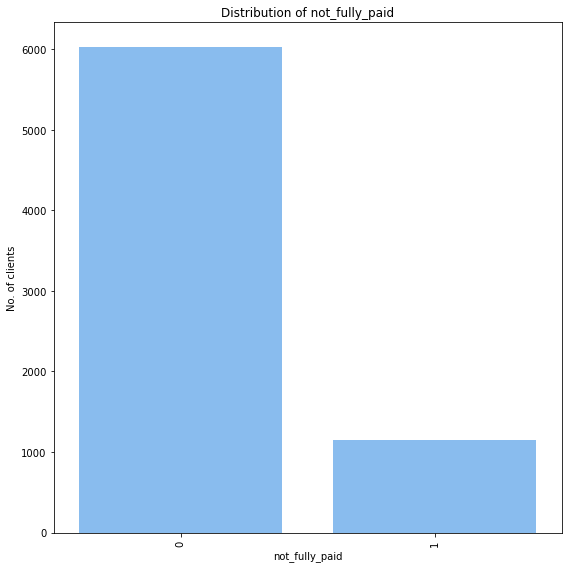

In [30]:
# Checking the distribution of fully paid & not
plt.figure(figsize=(8, 8))
# Plot distribution 
for i, col in enumerate(['not_fully_paid']):
    order = train[col].value_counts().index   
    plt.subplot(1,1,i+1)
    sns.countplot(train[col],color='dodgerblue', order = order,alpha=0.6 ) 
    plt.title(f'Distribution of {col}')
    plt.ylabel('No. of clients')
    plt.xticks(rotation=90)
# Show the plot
plt.tight_layout()
plt.show()

From the above distribution, there has been a huge class imabalance with target variables. TO avoid the chances of false preditions, we need to thing & apply some changes to the input information by re-sampling the data 

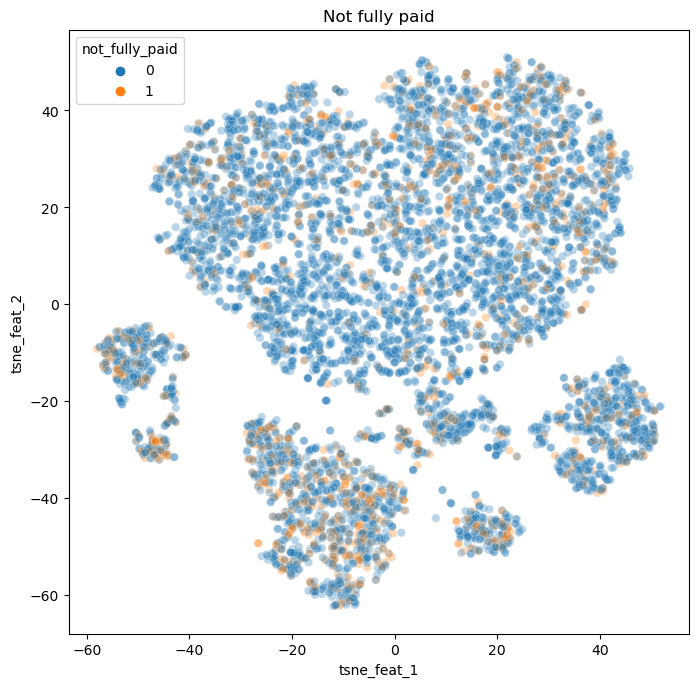

In [31]:
plt.figure(figsize=(8,8), dpi=100)
sns.scatterplot(x="tsne_feat_1", y="tsne_feat_2", hue='not_fully_paid', data=df_tsne, alpha=0.3)
plt.title("Not fully paid")
plt.show()

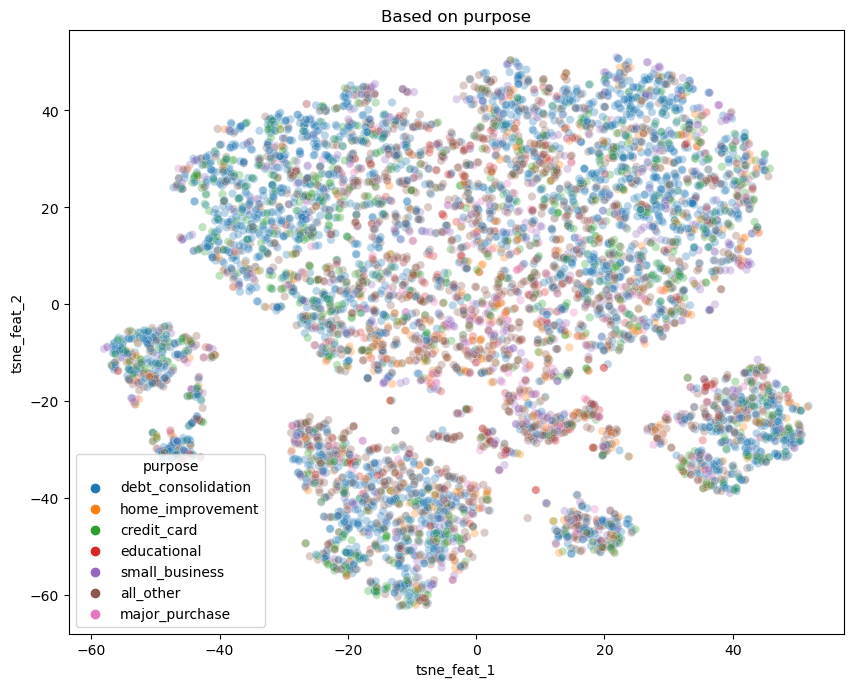

In [32]:
plt.figure(figsize=(10,8), dpi=100)
sns.scatterplot(x="tsne_feat_1", y="tsne_feat_2", hue='purpose', data=df_tsne, alpha=0.3)
plt.title("Based on purpose")
plt.show()

Based `t-SNE`, We weren't able to find any ideal clusters that could us to a better prediction. Moreover, all the data points from both target classes has co-existed together. 

In [33]:
def purpose_loan():
    plt.figure(figsize=(12,20),dpi=100)
    train_pur = (train.groupby(['purpose','not_fully_paid'])['credit_policy'].count()/train.groupby(['purpose'])['credit_policy'].count())
    train_pur.unstack().plot.bar(stacked=False)
    plt.ylabel('percentage')
    plt.title('Stacked bar plot '+str('purpose'))
    plt.show()

<Figure size 1200x2000 with 0 Axes>

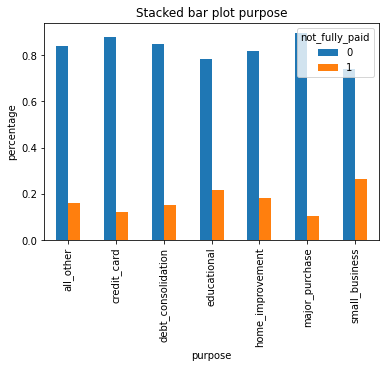

In [34]:
purpose_loan()

From the above distribution, we can clearly see that `small_business`, `educational`, `home_improvements` has high propotion of `not_fully_paid` records. And more likely `debt_consolidation` has also given close results to `home_improvements`. But `small_business` & `educational` purpose have higher rate than any other. In case of small_business, the chance of gaining profit for their investments are low. And the main reason could be the market rate flutuation & other regional situations, which explains the reason behind this distribution.

# Feature Selection

Based on previous analysis, it is clear that `purpose` categories has given some lead to investigate the chances of `not_fully_paid`. So before performing PCA analysis, let's break down the target variable to categorical feature variables & start analysing them individually.

In [35]:
train['Y'] = np.where(train['not_fully_paid']==1, 'yes', 'no')

In [36]:
train.head()

,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid,Y
2058,1,debt_consolidation,0.1568,310.64,10.279318,19.53,692,3738.000000,21894,99.5,0,0,0,0,no
9316,0,home_improvement,0.1183,256.79,10.736310,13.31,722,4560.000000,7562,57.7,4,0,0,1,yes
5411,1,credit_card,0.0894,413.03,10.861458,18.99,747,3209.958333,14385,50.3,1,0,0,0,no
1166,1,educational,0.1355,232.63,11.156251,24.22,687,3749.958333,8547,55.1,1,1,0,0,no
8329,0,debt_consolidation,0.1450,137.69,10.566072,22.05,657,3269.000000,8623,71.0,3,0,0,0,no


In [37]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7183 entries, 2058 to 7270
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit_policy      7183 non-null   int64  
 1   purpose            7183 non-null   object 
 2   int_rate           7183 non-null   float64
 3   installment        7183 non-null   float64
 4   log_annual_inc     7183 non-null   float64
 5   dti                7183 non-null   float64
 6   fico               7183 non-null   int64  
 7   days_with_cr_line  7183 non-null   float64
 8   revol_bal          7183 non-null   int64  
 9   revol_util         7183 non-null   float64
 10  inq_last_6mths     7183 non-null   int64  
 11  delinq_2yrs        7183 non-null   int64  
 12  pub_rec            7183 non-null   int64  
 13  not_fully_paid     7183 non-null   int64  
 14  Y                  7183 non-null   object 
dtypes: float64(6), int64(7), object(2)
memory usage: 1.1+ MB


In [38]:
# Filtered data for not fully paid records
train[train['Y']=='yes'].describe()

,credit_policy,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid
count,1150.000000,1150.000000,1150.000000,1150.000000,1150.000000,1150.000000,1150.000000,1150.000000,1150.000000,1150.000000,1150.000000,1150.000000,1150.0
mean,0.661739,0.131909,343.303470,10.893981,13.249287,698.626087,4418.509348,20527.616522,51.453304,2.348696,0.164348,0.093043,1.0
std,0.473324,0.025416,222.239018,0.665150,7.075205,35.056950,2505.274005,40630.550418,29.316071,2.979941,0.509217,0.296549,0.0
min,0.000000,0.070500,15.910000,7.600902,0.000000,617.000000,180.041667,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.000000,0.114800,168.760000,10.491274,7.632500,672.000000,2680.250000,3302.250000,28.600000,0.000000,0.000000,0.000000,1.0
50%,1.000000,0.131100,288.870000,10.896739,13.275000,692.000000,4050.000000,8799.000000,53.100000,1.000000,0.000000,0.000000,1.0
75%,1.000000,0.148200,493.302500,11.264464,19.120000,722.000000,5579.989583,21111.750000,76.975000,3.000000,0.000000,0.000000,1.0
max,1.000000,0.216400,918.020000,13.458836,29.960000,822.000000,15692.000000,508961.000000,106.500000,33.000000,4.000000,2.000000,1.0


In [39]:
# Filtered data for fully paid records
train[train['Y']=='no'].describe()

,credit_policy,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid
count,6033.000000,6033.000000,6033.000000,6033.000000,6033.000000,6033.000000,6033.000000,6033.000000,6033.000000,6033.000000,6033.000000,6033.000000,6033.0
mean,0.832587,0.120793,313.083315,10.941297,12.484626,713.364164,4596.204404,15959.065639,45.594502,1.447539,0.168904,0.056522,0.0
std,0.373375,0.026913,202.827088,0.599578,6.848576,38.239987,2507.962284,30028.242098,28.865328,2.018386,0.569868,0.253531,0.0
min,0.000000,0.060000,15.670000,7.547502,0.000000,622.000000,180.041667,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,1.000000,0.098800,160.780000,10.586584,7.130000,682.000000,2850.000000,3156.000000,21.300000,0.000000,0.000000,0.000000,0.0
50%,1.000000,0.121800,266.360000,10.933107,12.530000,707.000000,4140.041667,8476.000000,44.600000,1.000000,0.000000,0.000000,0.0
75%,1.000000,0.138500,420.020000,11.297341,17.760000,742.000000,5730.000000,17771.000000,69.300000,2.000000,0.000000,0.000000,0.0
max,1.000000,0.212100,926.830000,14.180154,29.950000,827.000000,17639.958330,952013.000000,108.800000,31.000000,13.000000,4.000000,0.0


To identify the key numerical components or attributes that are relatively changing based on our target variables, we need to visualise our data. So in order to gather some evidence, we need to look on initial `train_test` splits

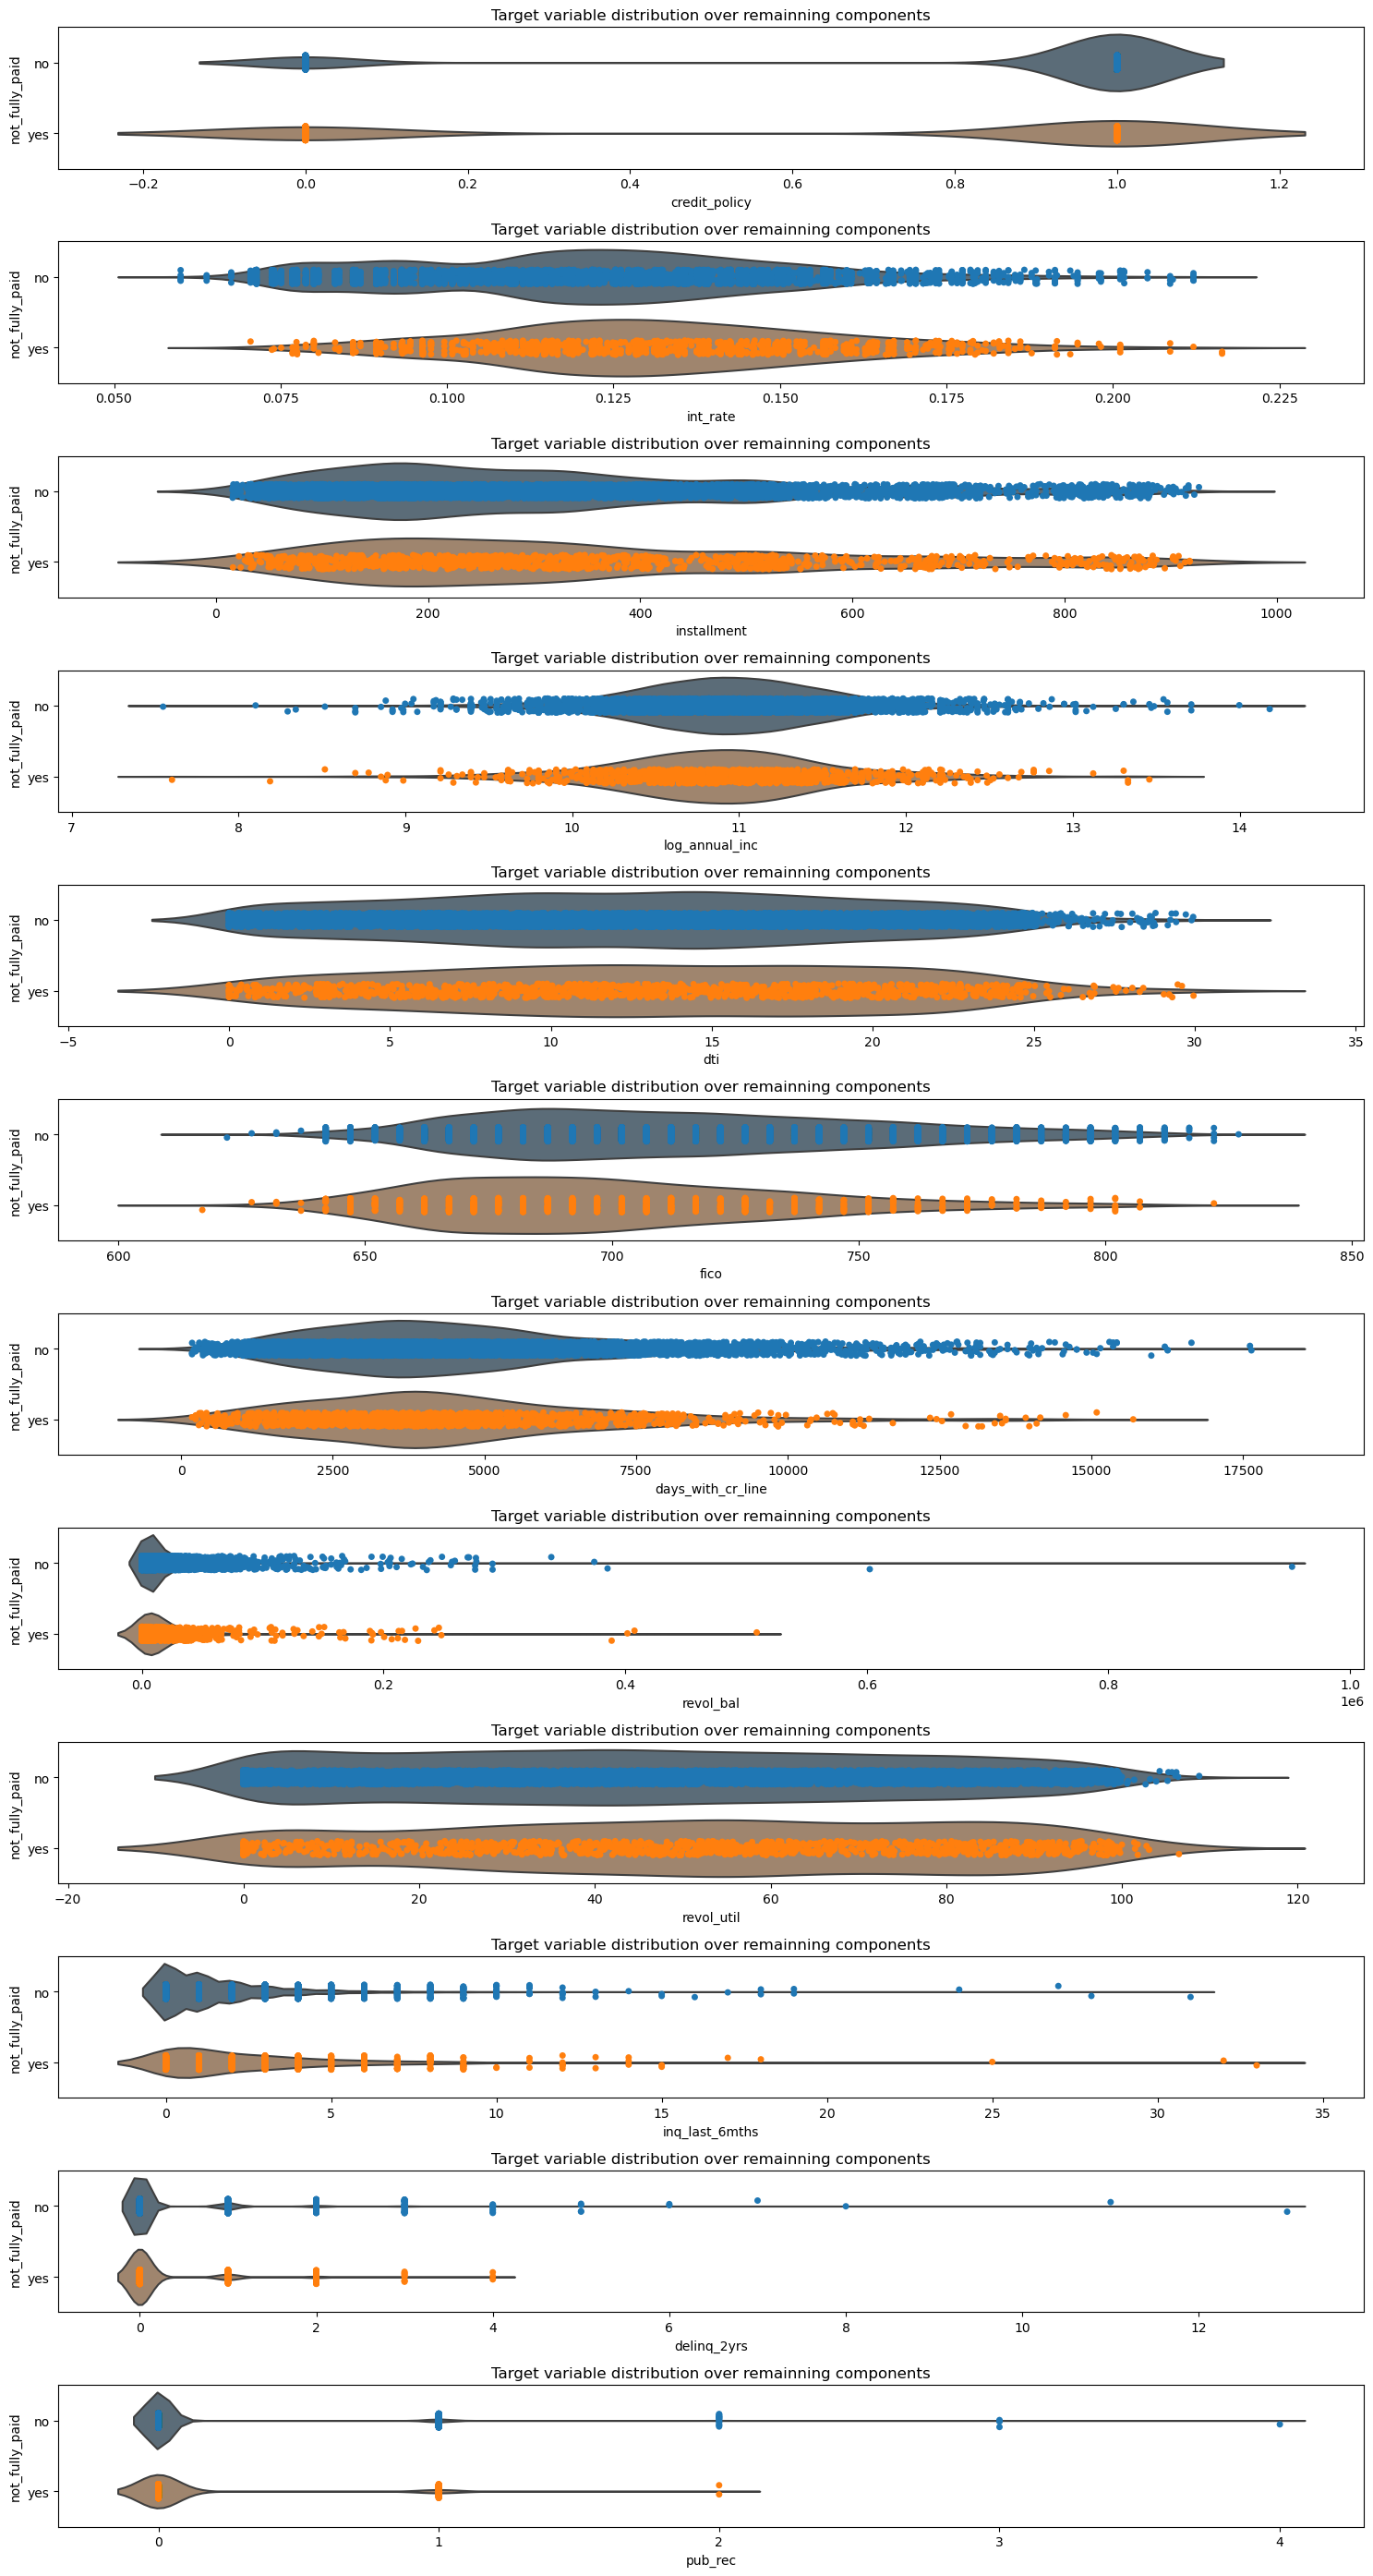

In [40]:
plt.figure(figsize=(15,28), dpi=100)

for i,j in enumerate(nums):
    plt.subplot(12,1,i+1)
#     sns.set_theme(style="whitegrid")
    sns.violinplot(x=j, y='Y', data=train, inner=None, saturation=0.2, style="whitegrid")
    sns.stripplot(x=j, y='Y', data=train, jitter=True, zorder=1)
    plt.title('Target variable distribution over remainning components')
    plt.ylabel('not_fully_paid')
plt.tight_layout()
plt.show()

From above distributions, our data suggests that loans `not_fully_paid` are generally have higher interest rate with increased number of inquiries by creditors `inq_last_6mnths`, lower revolving balance, lower FICO & credit policy.


In [41]:
# i,j = X_train_log_nw, Y_train
# data = pd.concat([i,j], axis=1)
    
# non_paid = data[data['not_fully_paid']==1]
# paid = data[data['not_fully_paid']==0]
    
# #oversampling the target variable by upscaling minority samples
# data_oversampled = resample(paid, replace=True, n_samples=len(non_paid), random_state=42)
# oversampled = pd.concat([non_paid, data_oversampled])

# plt.figure(figsize=(8, 8))
# # Plot distribution 
# for i, col in enumerate(['not_fully_paid']):
#     order = oversampled[col].value_counts().index   
#     plt.subplot(1,1,i+1)
#     sns.countplot(oversampled[col],color='dodgerblue', order = order,alpha=0.6 ) 
#     plt.title(f'Distribution of {col}')
#     plt.ylabel('No. of clients')
#     plt.xticks(rotation=90)
# # Show the plot
# plt.tight_layout()
# plt.show()


In [42]:
# oversampled.info()

In [43]:
def oversamp_data(i,j):
    data = pd.concat([i,j], axis=1)
    
    non_paid = data[data['not_fully_paid']==1]
    paid = data[data['not_fully_paid']==0]
    
    #oversampling the target variable by downscaling majority samples
    data_oversampled = resample(paid, replace=True, n_samples=len(non_paid), random_state=42)
    oversampled = pd.concat([non_paid, data_oversampled])
      
    X=oversampled.drop('not_fully_paid',axis=1)
    Y=oversampled[['not_fully_paid']]
    
    return X,Y

In [44]:
X_train_os, Y_train_os = oversamp_data(X_train_log_nw, Y_train)
X_test_os, Y_test_os = oversamp_data(X_test_log_nw, Y_test)
X_valid_os, Y_valid_os = oversamp_data(X_valid_log_nw, Y_valid)

In [45]:
X_train_os.head()

,credit_policy,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
9316,-2.033318,-0.146872,0.028298,-0.323253,0.339204,0.315701,0.261201,0.154566,0.522691,1.356019,-0.349177,-0.246035,-0.386843,-0.837934,-0.193019,3.836369,-0.221177,-0.262183
415,0.491807,-0.539949,0.508817,0.583031,-0.370651,-0.347970,0.407390,0.555094,0.823110,-0.022760,2.076812,-0.246035,-0.386843,-0.837934,-0.193019,-0.260663,-0.221177,3.814134
8783,-2.033318,1.945853,0.094574,-0.060557,1.289474,-1.035850,-0.076570,0.670205,0.590494,1.862322,2.076812,-0.246035,2.585025,-0.837934,-0.193019,-0.260663,-0.221177,-0.262183
1385,0.491807,0.879922,1.678264,1.718027,-0.150346,-0.757680,0.532454,0.277677,0.305539,-0.022760,3.495925,-0.246035,2.585025,-0.837934,-0.193019,-0.260663,-0.221177,-0.262183
654,0.491807,-0.566287,1.364113,0.243032,-1.456619,0.315701,-1.721294,0.026117,-0.505353,-0.022760,-0.349177,-0.246035,-0.386843,1.193412,-0.193019,-0.260663,-0.221177,-0.262183


In [46]:
X_valid_os.shape

(766, 18)

In [47]:
X_train_os.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2300 entries, 9316 to 909
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   credit_policy               2300 non-null   float64
 1   int_rate                    2300 non-null   float64
 2   installment                 2300 non-null   float64
 3   log_annual_inc              2300 non-null   float64
 4   dti                         2300 non-null   float64
 5   fico                        2300 non-null   float64
 6   days_with_cr_line           2300 non-null   float64
 7   revol_bal                   2300 non-null   float64
 8   revol_util                  2300 non-null   float64
 9   inq_last_6mths              2300 non-null   float64
 10  delinq_2yrs                 2300 non-null   float64
 11  pub_rec                     2300 non-null   float64
 12  purpose_credit_card         2300 non-null   float64
 13  purpose_debt_consolidation  230

Based on above resampled data, we've 18 features that are useful to train or model. Before that, we need to perform `PCA` analysis to reduce the dimensionality features for training a model.

In [48]:
n=18 # Total no.of features
dimensions = []

for i in range(1,n+1):
    dimensions.append('PCA_{}'.format(i))
# dimensions = np.asarray(dimensions)
# dimensions.shape

In [49]:
X_train_log_nw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7183 entries, 2058 to 7270
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   credit_policy               7183 non-null   float64
 1   int_rate                    7183 non-null   float64
 2   installment                 7183 non-null   float64
 3   log_annual_inc              7183 non-null   float64
 4   dti                         7183 non-null   float64
 5   fico                        7183 non-null   float64
 6   days_with_cr_line           7183 non-null   float64
 7   revol_bal                   7183 non-null   float64
 8   revol_util                  7183 non-null   float64
 9   inq_last_6mths              7183 non-null   float64
 10  delinq_2yrs                 7183 non-null   float64
 11  pub_rec                     7183 non-null   float64
 12  purpose_credit_card         7183 non-null   float64
 13  purpose_debt_consolidation  71

In [50]:
pca = PCA(n_components=n)
pc_X = pca.fit_transform(X_train_log_nw)
df_components = pd.DataFrame(pc_X, columns=dimensions, index=X_train_log_nw.index)
df_components.head()

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17,PCA_18
2058,-1.686983,-0.238999,-1.698859,-0.867300,-0.556163,-0.135729,-0.194962,-0.235669,-0.400342,0.501577,0.062835,0.527321,0.153546,-0.186435,-0.755943,-0.002336,-0.381350,0.330316
9316,-0.259890,0.542586,1.942071,0.950844,2.931950,-0.212505,-0.685882,-1.478856,-1.179759,1.289762,-0.947947,0.620610,-0.490276,0.604242,-0.988742,-0.190157,0.439346,0.314620
5411,0.461038,-1.266983,-0.717341,2.348602,-0.282594,-0.540627,0.315986,-0.206157,-0.320804,-1.241552,0.348939,0.659461,-1.106166,0.228248,0.159289,-0.176071,0.389669,0.083081
1166,-0.743094,0.884393,-0.163499,0.997832,-0.708512,1.223170,-3.550497,-0.107788,3.639916,1.209292,1.294073,0.320382,-0.534750,0.296589,0.909707,-0.221677,0.162646,0.251898
8329,-2.402112,1.807007,-0.312947,-0.293384,1.168106,-0.549372,0.343127,-0.120466,0.236542,-0.416854,-0.687884,0.107774,0.768239,0.234915,-0.333998,-0.369747,0.057896,-0.123969


In [51]:
pca.explained_variance_ratio_

array([0.15901324, 0.12322968, 0.08861194, 0.07497447, 0.06375535,
       0.06228746, 0.05782329, 0.05591532, 0.05521196, 0.05433454,
       0.04827946, 0.03991626, 0.02912211, 0.02712678, 0.02423351,
       0.01637252, 0.01113048, 0.00866164])

In [52]:
np.cumsum(pca.explained_variance_ratio_)

array([0.15901324, 0.28224292, 0.37085486, 0.44582932, 0.50958468,
       0.57187213, 0.62969542, 0.68561074, 0.7408227 , 0.79515725,
       0.8434367 , 0.88335296, 0.91247506, 0.93960185, 0.96383536,
       0.98020787, 0.99133836, 1.        ])

In [53]:
data = pd.DataFrame({'Variance ratio': pca.explained_variance_ratio_, 'Components':dimensions})

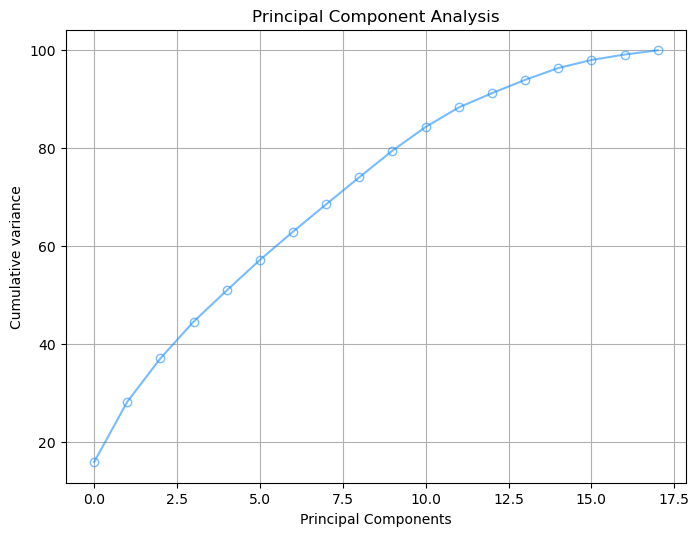

In [54]:
plt.figure(figsize=(8,6),dpi=100)
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100,'k-o',markerfacecolor='None',color='dodgerblue',alpha=0.6)
# plt.xlim([0,18])
# plt.ylim([0,105,10])
plt.title('Principal Component Analysis')
plt.xlabel('Principal Components')
plt.ylabel('Cumulative variance')
plt.grid(True)
plt.show()

From above graphs, it is clear that we can explain more than `90% of variance with 12 components`[with indexing 0]. So, we will set our `n_components=12`.

In [55]:
df_PCA = pd.concat([df_components,Y_train],axis=1)
df_PCA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7183 entries, 2058 to 7270
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PCA_1           7183 non-null   float64
 1   PCA_2           7183 non-null   float64
 2   PCA_3           7183 non-null   float64
 3   PCA_4           7183 non-null   float64
 4   PCA_5           7183 non-null   float64
 5   PCA_6           7183 non-null   float64
 6   PCA_7           7183 non-null   float64
 7   PCA_8           7183 non-null   float64
 8   PCA_9           7183 non-null   float64
 9   PCA_10          7183 non-null   float64
 10  PCA_11          7183 non-null   float64
 11  PCA_12          7183 non-null   float64
 12  PCA_13          7183 non-null   float64
 13  PCA_14          7183 non-null   float64
 14  PCA_15          7183 non-null   float64
 15  PCA_16          7183 non-null   float64
 16  PCA_17          7183 non-null   float64
 17  PCA_18          7183 non-null 

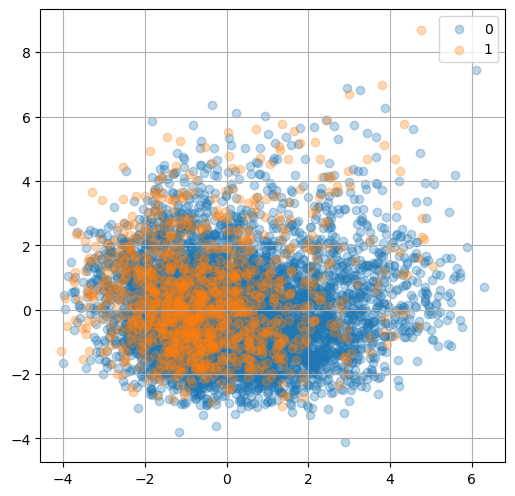

In [56]:
target_val = [0,1]
colors=['orange','blue']
fig,ax = plt.subplots(figsize=(6,6),dpi=100)

for target, color in zip(target_val,colors):
    temp = df_PCA['not_fully_paid'] == target
    ax.scatter(df_PCA.loc[temp,'PCA_1'], df_PCA.loc[temp,'PCA_2'],alpha=0.3)
ax.legend(target_val)
ax.grid()
plt.show()

Based on `df_PCA`, now we can partially see the clusters here. with 3D view, our clusters may or may not looks like overlapping. But the resulting outcome was better than before.

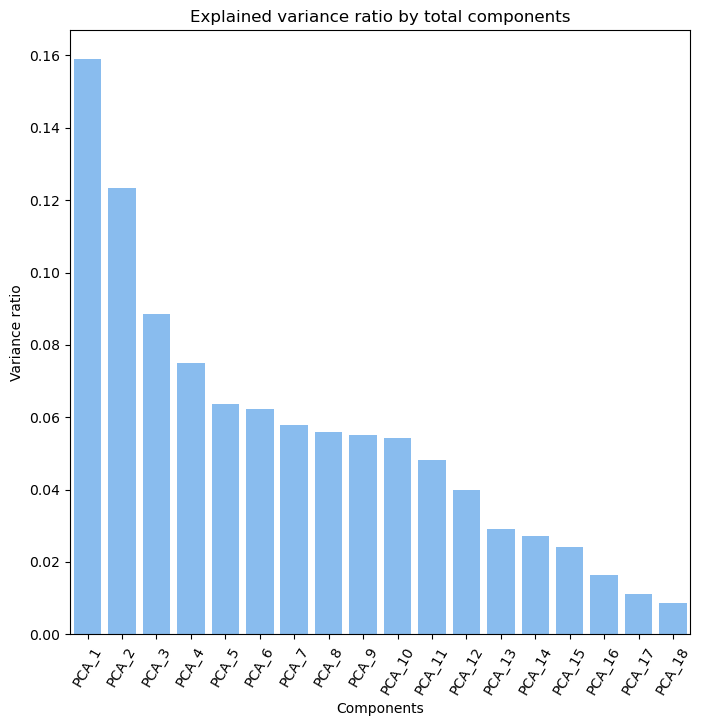

In [57]:
plt.figure(figsize=(8,8),dpi=100)
sns.barplot(x='Components',y='Variance ratio', data=data, color='dodgerblue', alpha=0.6)
plt.title('Explained variance ratio by total components')
plt.xticks(rotation=60)
plt.show()

# Optimal error point [Hyperparameters]

In [58]:
def optimal_error(model, C, train_error, valid_error):
    
    C_values = pd.DataFrame(C)
    valid_errors = pd.DataFrame(valid_error)
    minimum_error = min(valid_errors[0])
    minimum_index = valid_errors[0].idxmin(axis=1)
    minimum_C = C_values.loc[minimum_index,0]
    print('For '+str(model)+'model, minimal error point occurs at'+' C = '+str(round(minimum_C,5))+' & error = '+str(round(minimum_error,5)))
    
    plt.figure(figsize=(6,4), dpi=100)
    plt.semilogx(C, train_error, C, valid_error)
    plt.annotate('Minimal error',xy=(minimum_C, minimum_error),arrowprops=dict(facecolor='orange',shrink=0.4),)
    plt.legend(('train','validation'))
    plt.title(model)
    plt.xlabel('hyper-parameter')
    plt.ylabel('Error')
    plt.show()
    
    return {'Model':model, 'Best Hyperparameter': minimum_C}

### Logistic Regression

For Logistic regressionmodel, minimal error point occurs at C = 0.00398 & error = 0.36554


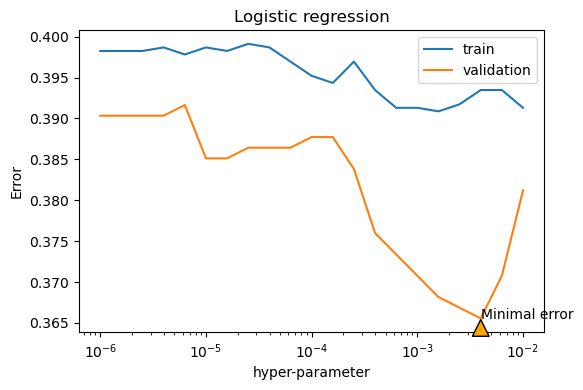

In [59]:
min_C = list()

train_errs = list()
valid_errs = list()
C_values = np.logspace(-6, -2, 21)

# Loop over values of C_value
for C_value in C_values:
    clf = LogisticRegression(C=C_value,random_state=42)
    clf.fit(X_train_os, Y_train_os)
    train_errs.append(1.0 - clf.score(X_train_os, Y_train_os))
    valid_errs.append(1.0 - clf.score(X_valid_os, Y_valid_os))

min_C.append(optimal_error('Logistic regression', C_values, train_errs, valid_errs))

### XGBoost

For Gradient boostingmodel, minimal error point occurs at C = 45 & error = 0.40339


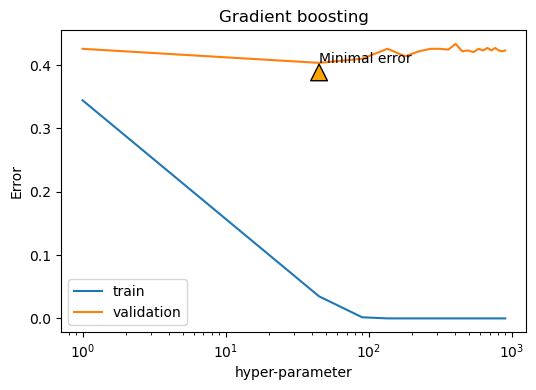

In [60]:
from xgboost.sklearn import XGBClassifier
train_errs = list()
valid_errs = list()
C_values = [int(x) for x in np.linspace(1, 900, 21)]

for C_value in C_values:
    clf = XGBClassifier(n_estimators=C_value,eval_metric='logloss',random_state=42)
    clf.fit(X_train_os, Y_train_os.values.ravel())
    train_errs.append( 1.0 - clf.score(X_train_os, Y_train_os) )
    valid_errs.append( 1.0 - clf.score(X_valid_os, Y_valid_os) )
    
min_C.append(optimal_error('Gradient boosting', C_values, train_errs, valid_errs))

### Random Forest

For Random Forest Classifiermodel, minimal error point occurs at C = 585 & error = 0.37467


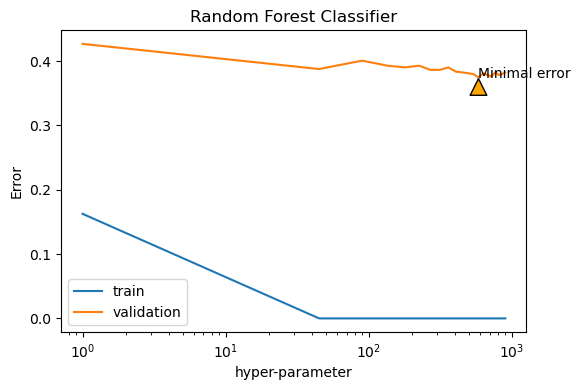

In [61]:
train_errs = list()
valid_errs = list()
C_values = [int(x) for x in np.linspace(1, 900, 21)]

for C_value in C_values:
    clf = RandomForestClassifier(n_estimators=C_value,random_state=42)
    clf.fit(X_train_os, Y_train_os)
    train_errs.append( 1.0 - clf.score(X_train_os, Y_train_os) )
    valid_errs.append( 1.0 - clf.score(X_valid_os, Y_valid_os) )
    
min_C.append(optimal_error('Random Forest Classifier', C_values, train_errs, valid_errs))

### KNeighborsClassifier

In [62]:
%%time
# leaf_size = list(range(1,50))
# n_neighbors = list(range(1,50))
# p=[1,2]
# weights = ['uniform','distance']

# hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p, weights=weights)
# knn = KNeighborsClassifier()
# clf = GridSearchCV(knn, hyperparameters, cv=5)
# best_model = clf.fit(X_valid_os, Y_valid_os)
for k in range(1,100,5):
    k=k+1
    clf = KNeighborsClassifier(n_neighbors=k).fit(X_train_os, Y_train_os)
    acc = clf.score(X_valid_os, Y_valid_os)
    print('Accuracy for k= '+str(k)+'is: '+str(round(acc,3)))

Accuracy for k= 2is: 0.546
Accuracy for k= 7is: 0.59
Accuracy for k= 12is: 0.608
Accuracy for k= 17is: 0.598
Accuracy for k= 22is: 0.586
Accuracy for k= 27is: 0.606
Accuracy for k= 32is: 0.611
Accuracy for k= 37is: 0.611
Accuracy for k= 42is: 0.619
Accuracy for k= 47is: 0.62
Accuracy for k= 52is: 0.621
Accuracy for k= 57is: 0.631
Accuracy for k= 62is: 0.624
Accuracy for k= 67is: 0.621
Accuracy for k= 72is: 0.615
Accuracy for k= 77is: 0.61
Accuracy for k= 82is: 0.62
Accuracy for k= 87is: 0.631
Accuracy for k= 92is: 0.619
Accuracy for k= 97is: 0.611
Wall time: 885 ms


In [63]:
min_C.append({'Model':'KNN', 'Best Hyperparameter': 87})

For `k=87`, the model was working more effectively.

In [64]:
min_C = pd.DataFrame(min_C)
min_C.set_index('Model', inplace=True)
min_C

,Best Hyperparameter
Model,
Logistic regression,0.003981
Gradient boosting,45.000000
Random Forest Classifier,585.000000
KNN,87.000000


In [65]:
"""
from time import time
from sklearn.metrics import accuracy_score, fbeta_score
from sklearn.model_selection import cross_val_score
def train_predict(learner, X_train, Y_train, X_test, Y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - Y_train: income training set
       - X_test: features testing set
       - Y_test: income testing set
    '''
    
    results = {}
#     report = {}
    
    start = time() # Get start time
    learner = learner.fit(X_train[:],Y_train[:])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end-start
        
    # Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() # Get end time
    
    #  Calculate the total prediction time
    results['pred_time'] = start - end
            
    # TODO: Compute accuracy on the training samples which is y_train
    results['acc_train'] = accuracy_score(Y_train, predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(Y_test, predictions_test)
    
    # Compute cross validation scores on training samples
    results['cross_val_score'] = cross_val_score(learner, X_train,Y_train,cv=5)
    
    
    
    
    # Compute F-score on the the training samples using fbeta_score()
    results['f_train'] = fbeta_score(Y_train, predictions_train, beta=0.5)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(Y_test, predictions_test, beta=0.5)
       
  
    print("{} trained on samples.".format(learner.__class__.__name__))
    print(results)  
    print('\t')
    print(classification_report(Y_test,predictions_test)) # Computing classification report on training samples
    print('\n')
    # Return the results
    return results
"""


'\nfrom time import time\nfrom sklearn.metrics import accuracy_score, fbeta_score\nfrom sklearn.model_selection import cross_val_score\ndef train_predict(learner, X_train, Y_train, X_test, Y_test): \n    \'\'\'\n    inputs:\n       - learner: the learning algorithm to be trained and predicted on\n       - sample_size: the size of samples (number) to be drawn from training set\n       - X_train: features training set\n       - Y_train: income training set\n       - X_test: features testing set\n       - Y_test: income testing set\n    \'\'\'\n    \n    results = {}\n#     report = {}\n    \n    start = time() # Get start time\n    learner = learner.fit(X_train[:],Y_train[:])\n    end = time() # Get end time\n    \n    # Calculate the training time\n    results[\'train_time\'] = end-start\n        \n    # Get the predictions on the test set(X_test),\n    #       then get predictions on the first 300 training samples(X_train) using .predict()\n    start = time() # Get start time\n    pred

In [66]:
"""
clf_A = LogisticRegression(random_state=42,C=min_C.loc['Logistic regression', 'Best Hyperparameter'])
clf_B = XGBClassifier(random_state=42, eval_metric='logloss', n_estimators = int(min_C.loc['Gradient boosting', 'Best Hyperparameter']))
clf_C = RandomForestClassifier(random_state=42, n_estimators=int(min_C.loc['Random Forest Classifier', 'Best Hyperparameter']))
clf_D = KNeighborsClassifier(n_neighbors=int(min_C.loc['KNN','Best Hyperparameter']))

# Calculating the number of samples for 1%, 10%, and 100% of the training data
samples_100 = len(Y_train_os) # entire training set i.e. len(Y_train)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C, clf_D]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
#     results[clf_name] = \
    train_predict(clf, X_train_os, Y_train_os, X_test_os, Y_test_os)
"""

"\nclf_A = LogisticRegression(random_state=42,C=min_C.loc['Logistic regression', 'Best Hyperparameter'])\nclf_B = XGBClassifier(random_state=42, eval_metric='logloss', n_estimators = int(min_C.loc['Gradient boosting', 'Best Hyperparameter']))\nclf_C = RandomForestClassifier(random_state=42, n_estimators=int(min_C.loc['Random Forest Classifier', 'Best Hyperparameter']))\nclf_D = KNeighborsClassifier(n_neighbors=int(min_C.loc['KNN','Best Hyperparameter']))\n\n# Calculating the number of samples for 1%, 10%, and 100% of the training data\nsamples_100 = len(Y_train_os) # entire training set i.e. len(Y_train)\n\n# Collect results on the learners\nresults = {}\nfor clf in [clf_A, clf_B, clf_C, clf_D]:\n    clf_name = clf.__class__.__name__\n    results[clf_name] = {}\n#     results[clf_name] =     train_predict(clf, X_train_os, Y_train_os, X_test_os, Y_test_os)\n"

In [67]:
#ADD any additional experiments here

In [68]:
X_valid_os.info()
print(X_train_os.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 766 entries, 1383 to 3025
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   credit_policy               766 non-null    float64
 1   int_rate                    766 non-null    float64
 2   installment                 766 non-null    float64
 3   log_annual_inc              766 non-null    float64
 4   dti                         766 non-null    float64
 5   fico                        766 non-null    float64
 6   days_with_cr_line           766 non-null    float64
 7   revol_bal                   766 non-null    float64
 8   revol_util                  766 non-null    float64
 9   inq_last_6mths              766 non-null    float64
 10  delinq_2yrs                 766 non-null    float64
 11  pub_rec                     766 non-null    float64
 12  purpose_credit_card         766 non-null    float64
 13  purpose_debt_consolidation  766

In [69]:
X_train_valid = pd.concat([X_train_os,X_valid_os], axis=0)
X_train_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3066 entries, 9316 to 3025
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   credit_policy               3066 non-null   float64
 1   int_rate                    3066 non-null   float64
 2   installment                 3066 non-null   float64
 3   log_annual_inc              3066 non-null   float64
 4   dti                         3066 non-null   float64
 5   fico                        3066 non-null   float64
 6   days_with_cr_line           3066 non-null   float64
 7   revol_bal                   3066 non-null   float64
 8   revol_util                  3066 non-null   float64
 9   inq_last_6mths              3066 non-null   float64
 10  delinq_2yrs                 3066 non-null   float64
 11  pub_rec                     3066 non-null   float64
 12  purpose_credit_card         3066 non-null   float64
 13  purpose_debt_consolidation  30

In [70]:
Y_train_valid = pd.concat([Y_train_os,Y_valid_os], axis=0)
Y_train_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3066 entries, 9316 to 3025
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   not_fully_paid  3066 non-null   int64
dtypes: int64(1)
memory usage: 47.9 KB


# Feature importance - [Recursive feature elimination]

In [71]:
# RFE params
n_features_to_select = 12
step = 1

In [72]:
# RFE with logistic regression
rfe_lgr = RFE(estimator=LogisticRegression(random_state=42,C=min_C.loc['Logistic regression', 'Best Hyperparameter']), n_features_to_select=n_features_to_select, step=step, verbose=1)
rfe_lgr.fit(X_train_valid, Y_train_valid)
score=rfe_lgr.score(X_test_os, Y_test_os)
print('Logistic Regression can explain '+str(score)+ '% of variance in the test data')
lgr_mask = rfe_lgr.support_

Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Logistic Regression can explain 0.6344647519582245% of variance in the test data


In [73]:
# RFE with XGBClassifier
rfe_xgb = RFE(estimator=XGBClassifier(random_state=42, eval_metric='logloss', n_estimators = int(min_C.loc['Gradient boosting', 'Best Hyperparameter'])), n_features_to_select=n_features_to_select, step=step, verbose=1)
rfe_xgb.fit(X_train_valid, Y_train_valid)
score=rfe_xgb.score(X_test_os, Y_test_os)
print('XGBClassifier can explain '+str(score)+ '% of variance in the test data')
xgb_mask = rfe_xgb.support_

Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
XGBClassifier can explain 0.9203655352480418% of variance in the test data


In [74]:
# RFE with RFClassifier
rfe_rf = RFE(estimator=RandomForestClassifier(random_state=42, n_estimators=int(min_C.loc['Random Forest Classifier', 'Best Hyperparameter'])), n_features_to_select=n_features_to_select, step=step, verbose=1)
rfe_rf.fit(X_train_valid, Y_train_valid)
score=rfe_rf.score(X_test_os, Y_test_os)
print('RFClassifier can explain '+str(score)+ '% of variance in the test data')
rf_mask=rfe_rf.support_

Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
RFClassifier can explain 1.0% of variance in the test data


In [75]:
# Adding up all the three models votes
votes = np.sum([lgr_mask,xgb_mask,rf_mask], axis=0)
meta_mask = votes>=2
print('Following features are voted by more than 2 models:')
X_train_valid.loc[:,meta_mask].columns

Following features are voted by more than 2 models:


Index(['credit_policy', 'int_rate', 'installment', 'log_annual_inc', 'fico',
       'days_with_cr_line', 'revol_bal', 'revol_util', 'inq_last_6mths',
       'delinq_2yrs', 'purpose_debt_consolidation', 'purpose_major_purchase',
       'purpose_small_business'],
      dtype='object')

In [76]:
# Applying dimensionality reduction on X
X_train_mask = X_train_valid.loc[:,meta_mask]
X_test_mask = X_test_log_nw.loc[:,meta_mask]
X_train_mask.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3066 entries, 9316 to 3025
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   credit_policy               3066 non-null   float64
 1   int_rate                    3066 non-null   float64
 2   installment                 3066 non-null   float64
 3   log_annual_inc              3066 non-null   float64
 4   fico                        3066 non-null   float64
 5   days_with_cr_line           3066 non-null   float64
 6   revol_bal                   3066 non-null   float64
 7   revol_util                  3066 non-null   float64
 8   inq_last_6mths              3066 non-null   float64
 9   delinq_2yrs                 3066 non-null   float64
 10  purpose_debt_consolidation  3066 non-null   float64
 11  purpose_major_purchase      3066 non-null   float64
 12  purpose_small_business      3066 non-null   float64
dtypes: float64(13)
memory usage: 3

In [77]:
X_test_mask.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2395 entries, 8558 to 8216
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   credit_policy               2395 non-null   float64
 1   int_rate                    2395 non-null   float64
 2   installment                 2395 non-null   float64
 3   log_annual_inc              2395 non-null   float64
 4   fico                        2395 non-null   float64
 5   days_with_cr_line           2395 non-null   float64
 6   revol_bal                   2395 non-null   float64
 7   revol_util                  2395 non-null   float64
 8   inq_last_6mths              2395 non-null   float64
 9   delinq_2yrs                 2395 non-null   float64
 10  purpose_debt_consolidation  2395 non-null   float64
 11  purpose_major_purchase      2395 non-null   float64
 12  purpose_small_business      2395 non-null   float64
dtypes: float64(13)
memory usage: 2

In [78]:
# Implementing Logistic regression
lgr = LogisticRegression(random_state=42,C=min_C.loc['Logistic regression', 'Best Hyperparameter'])
lgr.fit(X_train_mask,Y_train_valid)
score=lgr.score(X_test_mask,Y_test)
print('Logistic Regression with dimension reduction can explain '+str(score)+ '% of variance in the test data')
y_pred = lgr.predict(X_test_mask)
acc_score = accuracy_score(Y_test,y_pred)
print('Accuracy score: '+str(acc_score))
print("auc:"+str(roc_auc_score(Y_test,y_pred)))
print('recall:'+str(recall_score(Y_test,y_pred)))
print(confusion_matrix(Y_test,y_pred))
print(classification_report(Y_test, y_pred))

Logistic Regression with dimension reduction can explain 0.6597077244258872% of variance in the test data
Accuracy score: 0.6597077244258872
auc:0.6315202778109411
recall:0.5900783289817232
[[1354  658]
 [ 157  226]]
              precision    recall  f1-score   support

           0       0.90      0.67      0.77      2012
           1       0.26      0.59      0.36       383

    accuracy                           0.66      2395
   macro avg       0.58      0.63      0.56      2395
weighted avg       0.79      0.66      0.70      2395



In [79]:
# implementing XGBClassifier
xgb = XGBClassifier(random_state=42, eval_metric='logloss', n_estimators = int(min_C.loc['Gradient boosting', 'Best Hyperparameter']))
xgb.fit(X_train_mask,Y_train_valid)
score=xgb.score(X_test_mask,Y_test)
print('XGBClassifier with dimension reduction can explain '+str(score)+ '% of variance in the test data')
y_pred = xgb.predict(X_test_mask)
acc_score = accuracy_score(Y_test,y_pred)
print('Accuracy score: '+str(acc_score))
print('AUC score:'+str(roc_auc_score(Y_test,y_pred)))
print(confusion_matrix(Y_test,y_pred))
print(classification_report(Y_test, y_pred))

XGBClassifier with dimension reduction can explain 0.6826722338204593% of variance in the test data
Accuracy score: 0.6826722338204593
AUC score:0.7857658228176633
[[1276  736]
 [  24  359]]
              precision    recall  f1-score   support

           0       0.98      0.63      0.77      2012
           1       0.33      0.94      0.49       383

    accuracy                           0.68      2395
   macro avg       0.65      0.79      0.63      2395
weighted avg       0.88      0.68      0.72      2395



In [80]:
# Implementing RandomForest
rf = RandomForestClassifier(random_state=42, n_estimators=int(min_C.loc['Random Forest Classifier', 'Best Hyperparameter']))
rf.fit(X_train_mask,Y_train_valid)
score=rf.score(X_test_mask,Y_test)
print('RandomForestClassifier with dimension reduction can explain '+str(score)+ '% of variance in the test data')
y_pred = rf.predict(X_test_mask)
acc_score = accuracy_score(Y_test,y_pred)
print('Accuracy score: '+str(acc_score))
print('AUC score:'+str(roc_auc_score(Y_test,y_pred)))
print('Recall: '+str(recall_score(Y_test,y_pred)))
print(confusion_matrix(Y_test,y_pred))
print(classification_report(Y_test, y_pred))

RandomForestClassifier with dimension reduction can explain 0.6847599164926931% of variance in the test data
Accuracy score: 0.6847599164926931
AUC score:0.812375745526839
Recall: 1.0
[[1257  755]
 [   0  383]]
              precision    recall  f1-score   support

           0       1.00      0.62      0.77      2012
           1       0.34      1.00      0.50       383

    accuracy                           0.68      2395
   macro avg       0.67      0.81      0.64      2395
weighted avg       0.89      0.68      0.73      2395



In [81]:
# Implementing KNN
knn = KNeighborsClassifier(n_neighbors=int(min_C.loc['KNN', 'Best Hyperparameter']))
knn.fit(X_train_mask,Y_train_valid)
score=knn.score(X_test_mask,Y_test)
print('KNeighborsClassifier with dimension reduction can explain '+str(score)+ '% of variance in the test data')
y_pred = knn.predict(X_test_mask)
acc_score = accuracy_score(Y_test,y_pred)
print('Accuracy score: '+str(acc_score))
print('AUC score:'+str(roc_auc_score(Y_test,y_pred)))
print(confusion_matrix(Y_test,y_pred))
print(classification_report(Y_test, y_pred))

KNeighborsClassifier with dimension reduction can explain 0.6826722338204593% of variance in the test data
Accuracy score: 0.6826722338204593
AUC score:0.6229918141282852
[[1430  582]
 [ 178  205]]
              precision    recall  f1-score   support

           0       0.89      0.71      0.79      2012
           1       0.26      0.54      0.35       383

    accuracy                           0.68      2395
   macro avg       0.57      0.62      0.57      2395
weighted avg       0.79      0.68      0.72      2395



Based on above implementation, `KNN` has lower performance compared to `lgr`,`XGB`,`RF`. Both `XGB` & `RF` has performed ideally closer. So, let's look at the feature ranking of XGB & RF models.

In [82]:
# Retrieving feature importance from RF & XGB

col_nam = X_test_mask.columns
model_rank = list()

def model_imp(model,label):
    tmp = dict()
    importance = model.feature_importances_
    indices = np.argsort(importance)[::-1]
    #Feature ranking
    print('Feature ranking for '+str(label))
    tmp['model'] = label
    for f in range(len(indices)):
        print("%d. %s (%f)" % (f + 1, col_nam[indices[f]], importance[indices[f]]))
        tmp[col_nam[indices[f]]] = importance[indices[f]]
    print (' ')
    return tmp        

In [83]:
model_rank.append(model_imp(rf,'Random Forest'))
model_rank.append(model_imp(xgb,'XGBClassifier'))
model_rank = pd.DataFrame(model_rank)
model_rank.set_index('model', inplace=True)
model_rank

Feature ranking for Random Forest
1. installment (0.129433)
2. int_rate (0.129144)
3. revol_util (0.127307)
4. log_annual_inc (0.126386)
5. days_with_cr_line (0.126041)
6. revol_bal (0.125213)
7. fico (0.099805)
8. inq_last_6mths (0.063111)
9. credit_policy (0.020739)
10. purpose_debt_consolidation (0.018174)
11. delinq_2yrs (0.016584)
12. purpose_small_business (0.011769)
13. purpose_major_purchase (0.006295)
 
Feature ranking for XGBClassifier
1. credit_policy (0.201037)
2. purpose_small_business (0.127413)
3. int_rate (0.087312)
4. inq_last_6mths (0.068449)
5. revol_util (0.063129)
6. purpose_major_purchase (0.062303)
7. log_annual_inc (0.057686)
8. installment (0.057443)
9. revol_bal (0.056457)
10. purpose_debt_consolidation (0.056397)
11. days_with_cr_line (0.055456)
12. delinq_2yrs (0.054416)
13. fico (0.052502)
 


,installment,int_rate,revol_util,log_annual_inc,days_with_cr_line,revol_bal,fico,inq_last_6mths,credit_policy,purpose_debt_consolidation,delinq_2yrs,purpose_small_business,purpose_major_purchase
model,,,,,,,,,,,,,
Random Forest,0.129433,0.129144,0.127307,0.126386,0.126041,0.125213,0.099805,0.063111,0.020739,0.018174,0.016584,0.011769,0.006295
XGBClassifier,0.057443,0.087312,0.063129,0.057686,0.055456,0.056457,0.052502,0.068449,0.201037,0.056397,0.054416,0.127413,0.062303


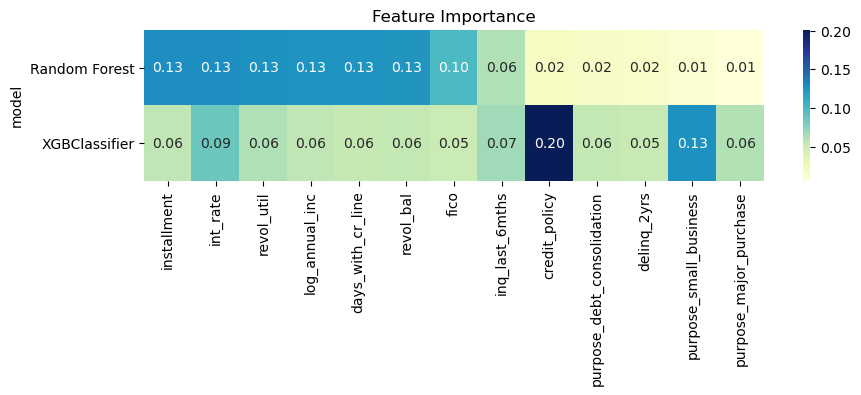

In [84]:
# Data correlation heatmap
plt.figure(figsize=(10,2),dpi=100)
plt.title('Feature Importance')
sns.heatmap(model_rank, annot=True, fmt='.2f', cmap='YlGnBu')
plt.yticks(rotation=360)
plt.show()

The feature importance ranking between `RF` & `XGBClassifier` is clearly differs. But based on previous EDA observations where loans not fully paid is largely correlated with `interest rate, number of inquiries in last 6 months, revol_bal, credit_policy & FICO` are close resemble.

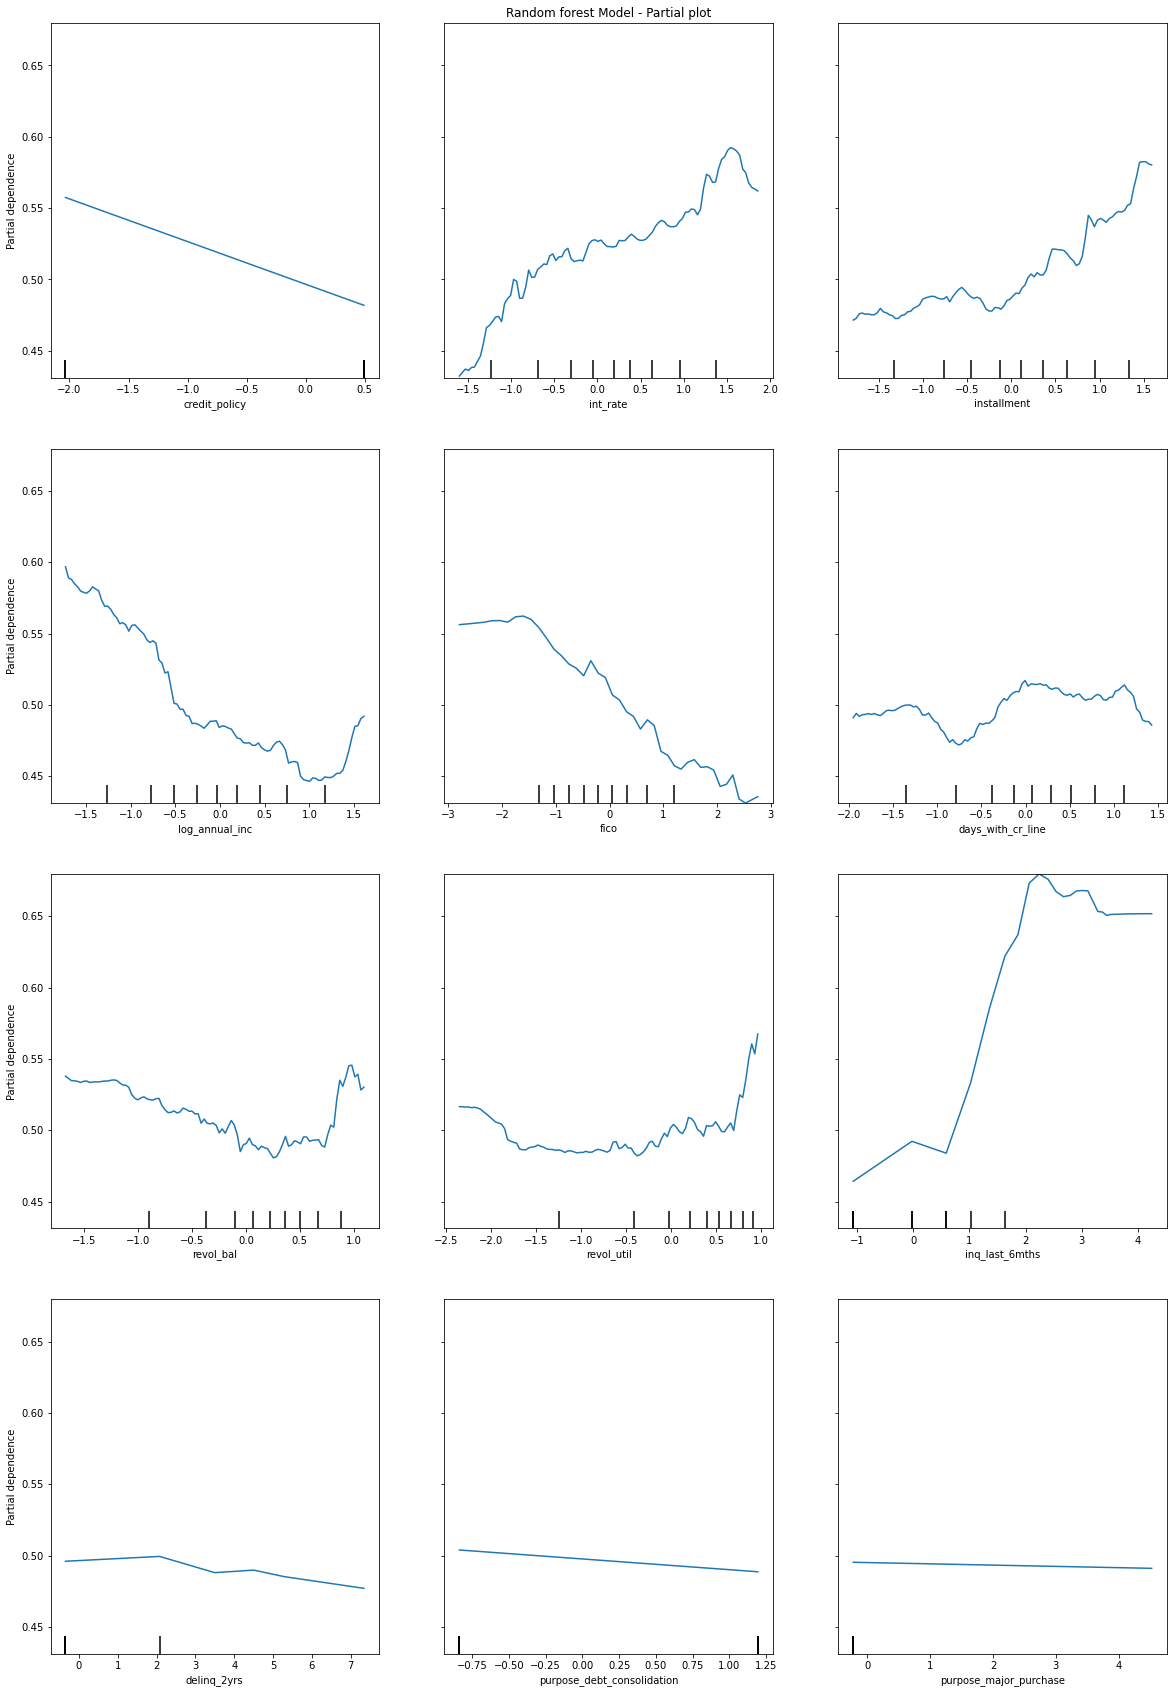

In [85]:
# Partial plot
fig, ax = plt.subplots(figsize=(20, 30))
ax.set_title("Random forest Model - Partial plot")
tree = plot_partial_dependence(rf, X_train_mask, list(range(0, 12)), ax=ax)

From the above plot, It is sure that loans with high interest rates, high FICO score & client with large number of inquiries tend to have higher loans unpaid.

Client's with bad credit scoring are generally charged with higher interest rates so that the lender can better protect himself from potential defaults. Moreover, clients with bad credit scoring might also be actively seeking credit lines, resulting in larger number of inquiries into their accounts.

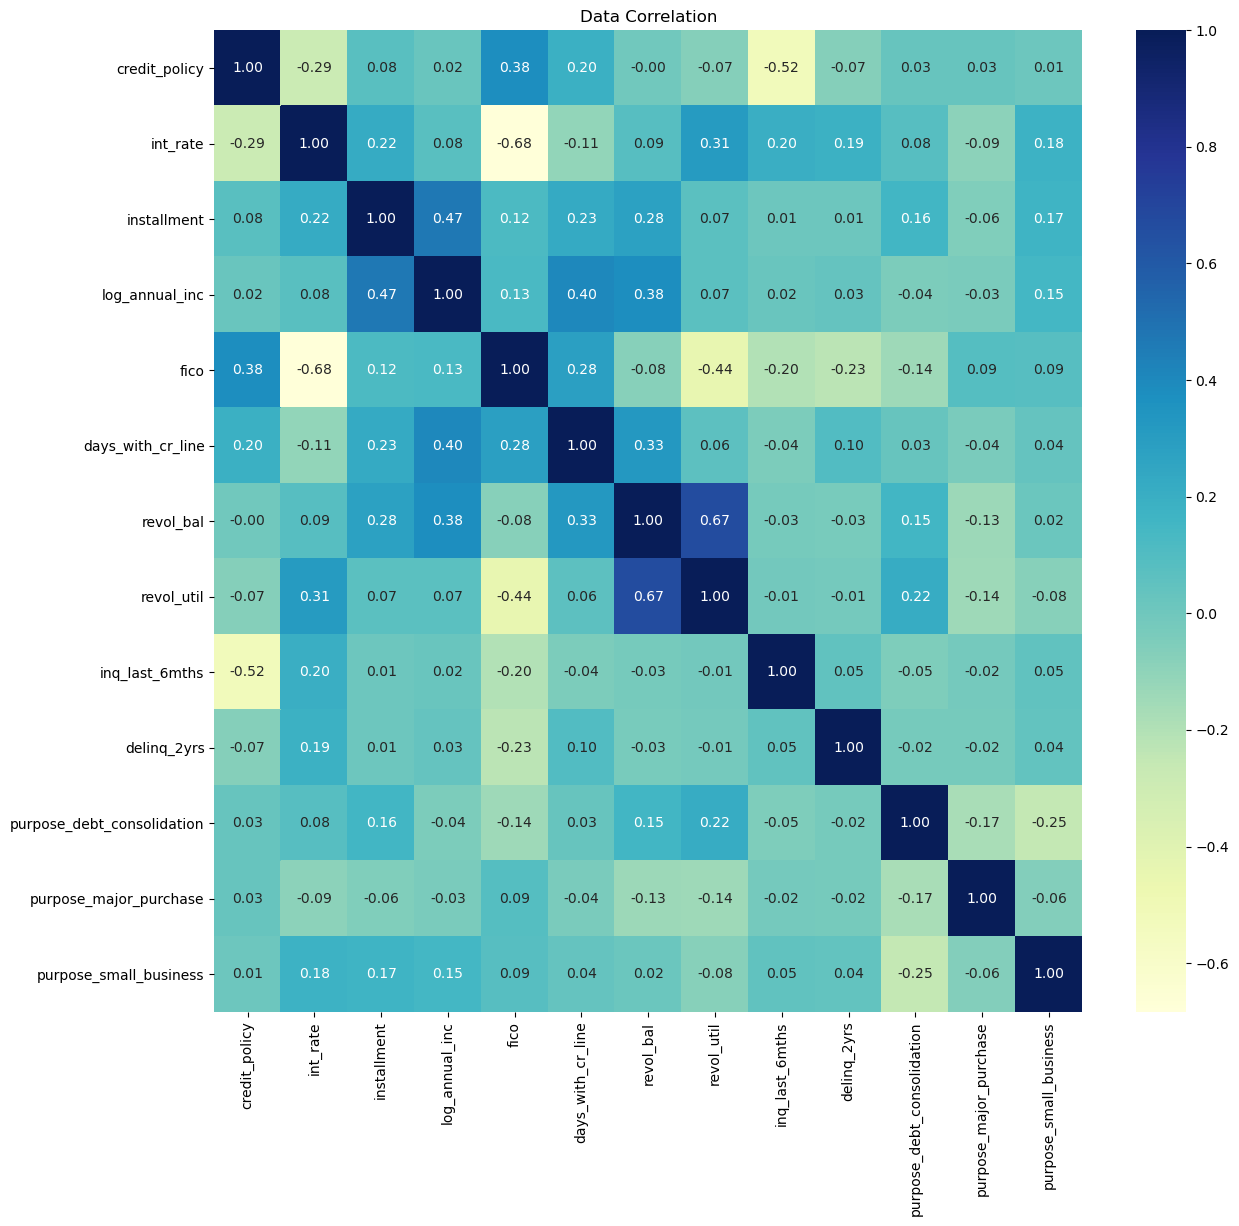

In [86]:
plt.figure(figsize=(14,13), dpi=100)
plt.title('Data Correlation')
sns.heatmap(X_train_mask.corr(), annot=True, fmt='.2f', cmap="YlGnBu")
plt.show()

It is clear that none of the selected features exhibit any multi-relationship(Collinearity).

# Modelling

In [87]:
final_result = list()  #List to store results
final_model = list() #List to store models

def model_train(model, clf,X=X_test, Y=Y_test):
    
    # Evaluate scores
    Y_test_predict = clf.predict(X)
    auc = roc_auc_score(Y,Y_test_predict)
    precision = precision_score(Y,Y_test_predict)
    recall = recall_score(Y,Y_test_predict)
    accuracy = clf.score(X,Y)
    
    # Classification report
    print('====== Classification model ['+str(model)+ '] =========')
    print(classification_report(Y,Y_test_predict))
#     print('precision: '+str(precision))
#     print('recall: '+str(recall))
#     print(confusion_matrix(Y_test,Y_test_predict))
    
    # Confusion matrix
    classes = [0,1]
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    # HeatMap
    sns.heatmap(pd.DataFrame(confusion_matrix(Y,Y_test_predict)), annot=True, cmap='YlGnBu', fmt='g')
    ax.xaxis.set_label_position('top')
    plt.tight_layout()
    plt.title(f'{model}- Confusion matrix', y=1.3)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()
    
    Y_pred_prob = clf.predict_proba(X)[:,1]
    # Generate FPR,TPR thresholds
    fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_prob)
    # Plot ROC curve
    plt.plot([0,1],[0,1], 'k--', label='No predictied')
    plt.plot(fpr, tpr, marker='.', label=model)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(f'{model} - ROC curve')
    plt.annotate(f'AUC ={round(auc, 5)} ', xy=(0.5, 0.4),fontsize=10,)
    plt.legend()
    plt.show()

    precision_, recall_, _ = precision_recall_curve(Y_test, Y_pred_prob)
    random_clf = Y_test[Y_test==1].count() / len(Y_test)
    plt.plot([0, 1], [random_clf, random_clf], linestyle='--', label='Average precision')
    plt.plot(recall_, precision_, marker='.', label=model)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{model} - Precision recall curve')
    plt.legend()
    plt.show()

    return {'Model':model, \
            'Accuracy': round(accuracy,5) , \
            'Precision':round(precision,5) , \
            'Recall':round(recall,5), \
            'AUC':round(auc,5)}
    

### Logistic (Feature Selected)

====== Classification model [Logistic regression(Feature selected)] =========
              precision    recall  f1-score   support

           0       0.84      1.00      0.91      2012
           1       0.56      0.01      0.03       383

    accuracy                           0.84      2395
   macro avg       0.70      0.51      0.47      2395
weighted avg       0.80      0.84      0.77      2395



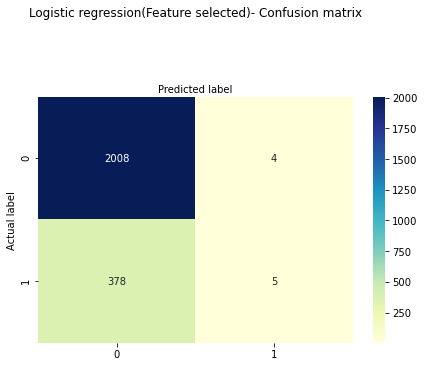

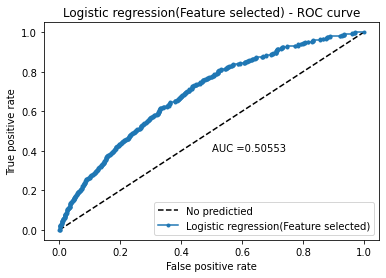

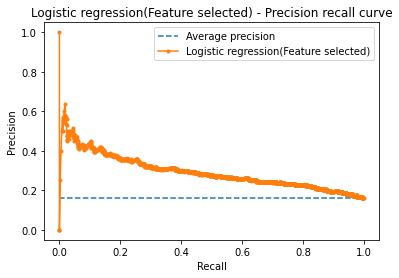

In [88]:
# Logistic regression with feature selected
clf_A = LogisticRegression(random_state=42)
clf_A.fit(X_train_log_nw, Y_train)
final_model.append(model_train('Logistic regression(Feature selected)', clf_A,X=X_test_log_nw, Y=Y_test))


### Logistic (Improved)

Applying k-fold cross validation to improve overfitting & SMOTE to overcome imbalance class, startification to prevent data leaks during cross validation.

In [89]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)
def param_search(model, pipe, new_params,kf):
    
    clf = GridSearchCV(pipe, param_grid=new_params, cv=kf, scoring='roc_auc',return_train_score=True)
    start_time = time()
    clf.fit(X_train_log_nw, Y_train)
    end_time = time()
    total_time=end_time-start_time
    clf.cv_results_['mean_test_score'], clf.cv_results_['mean_train_score']
    clf.best_score_
    clf.best_params_
    print(' Total Time: '+str(round(total_time,4)))
    print('--------Best Estimator--------')
    print(clf.best_estimator_)
    print(" ")
    print('--------Best Hyperparameters--------')
    print(clf.best_params_)
    print(" ")
    Y_test_predict = clf.best_estimator_.predict(X_test_log_nw)
    score = roc_auc_score(Y_test,Y_test_predict)
    
    return clf, {'Model':model, 'Best hyperparam': clf.best_params_, 'AUC':round(score,5)}

 Total Time: 5.6476
--------Best Estimator--------
Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('logisticregression',
                 LogisticRegression(C=0.0027825594022071257, random_state=42))])
 
--------Best Hyperparameters--------
{'logisticregression__C': 0.0027825594022071257, 'logisticregression__penalty': 'l2', 'logisticregression__random_state': 42}
 
====== Classification model [Logistic Regression (improved)] =========
              precision    recall  f1-score   support

           0       0.90      0.64      0.75      2012
           1       0.25      0.63      0.36       383

    accuracy                           0.64      2395
   macro avg       0.57      0.63      0.55      2395
weighted avg       0.80      0.64      0.69      2395



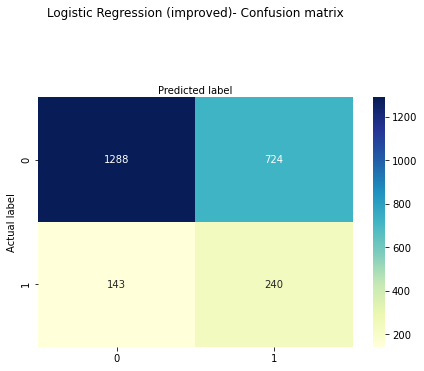

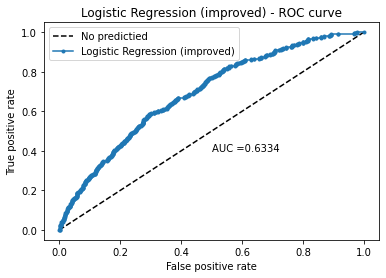

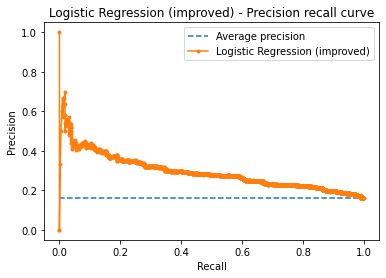

[{'Model': 'Logistic regression(Feature selected)',
  'Accuracy': 0.8405,
  'Precision': 0.55556,
  'Recall': 0.01305,
  'AUC': 0.50553},
 {'Model': 'Logistic Regression (improved)',
  'Accuracy': 0.69132,
  'Precision': 0.24896,
  'Recall': 0.62663,
  'AUC': 0.6334}]

In [90]:
# Logistic regression with k-fold, GridSearchCV
penalty = ['l1','l2','elasticnet','none'] #12
c_values = np.logspace(-7, 1, 10) #0.0027825594022071257

params = {
    'penalty': penalty,
    'C': c_values,
    'random_state': [42]
}
new_params = {'logisticregression__' + key: params[key] for key in params}

# Create pipeline
pipe = make_pipeline(SMOTE(random_state=42), 
                              LogisticRegression(penalty='l1' ,C=0, random_state=42))

lr_clf, lr = param_search('Logistic Regression (improved)', pipe, new_params,kf)

final_model.append(model_train('Logistic Regression (improved)', lr_clf, X=X_test_log_nw, Y=Y_test))
final_result.append(lr)
final_result
final_model

### KNN (Feature Selected)

====== Classification model [KNN (Feature selected)] =========
              precision    recall  f1-score   support

           0       0.85      0.97      0.90      2012
           1       0.33      0.09      0.14       383

    accuracy                           0.83      2395
   macro avg       0.59      0.53      0.52      2395
weighted avg       0.77      0.83      0.78      2395



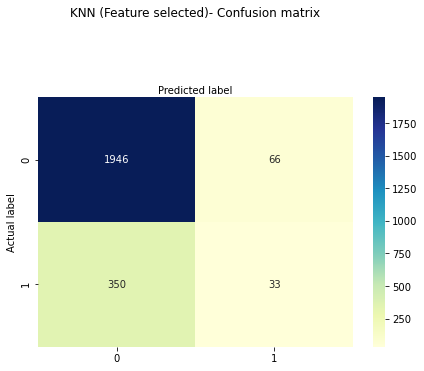

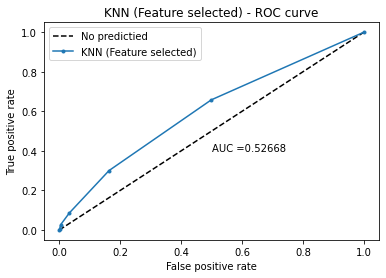

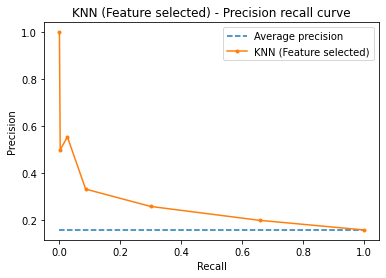

In [91]:
clf_B = KNeighborsClassifier()
clf_B.fit(X_train_log_nw, Y_train)
final_model.append(model_train('KNN (Feature selected)', clf_B,X=X_test_log_nw, Y=Y_test))

### KNN (Improved)

 Total Time: 5.7942
--------Best Estimator--------
Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('kneighborsclassifier',
                 KNeighborsClassifier(n_neighbors=95, p=1))])
 
--------Best Hyperparameters--------
{'kneighborsclassifier__n_neighbors': 95, 'kneighborsclassifier__p': 1, 'kneighborsclassifier__weights': 'uniform'}
 
====== Classification model [KNN (improved)] =========
              precision    recall  f1-score   support

           0       0.90      0.54      0.68      2012
           1       0.22      0.69      0.34       383

    accuracy                           0.57      2395
   macro avg       0.56      0.62      0.51      2395
weighted avg       0.79      0.57      0.62      2395



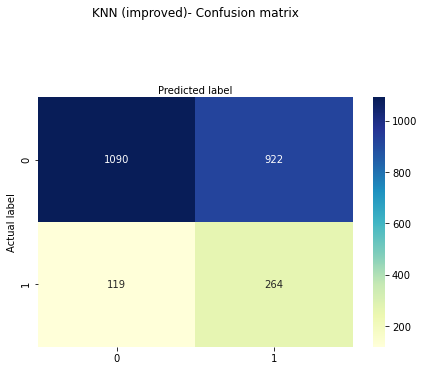

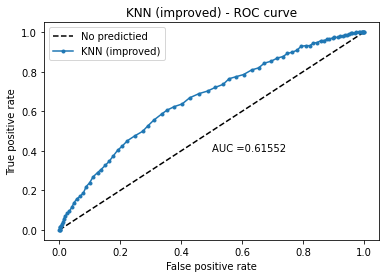

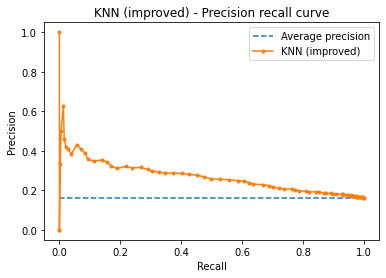

[{'Model': 'Logistic regression(Feature selected)',
  'Accuracy': 0.8405,
  'Precision': 0.55556,
  'Recall': 0.01305,
  'AUC': 0.50553},
 {'Model': 'Logistic Regression (improved)',
  'Accuracy': 0.69132,
  'Precision': 0.24896,
  'Recall': 0.62663,
  'AUC': 0.6334},
 {'Model': 'KNN (Feature selected)',
  'Accuracy': 0.8263,
  'Precision': 0.33333,
  'Recall': 0.08616,
  'AUC': 0.52668},
 {'Model': 'KNN (improved)',
  'Accuracy': 0.66178,
  'Precision': 0.2226,
  'Recall': 0.6893,
  'AUC': 0.61552}]

In [92]:
# KNN with k-fold, GridSearchCV
params = {
    "n_neighbors": [95],         #range(20, 100,5), #95
    "p": [1],            ##[1,2],  #1
    "weights": ['uniform']   #["uniform", "distance"] #uni
}
new_params = {'kneighborsclassifier__' + key: params[key] for key in params}

pipe = make_pipeline(SMOTE(random_state=42), KNeighborsClassifier())

knn_clf, knn = param_search('KNN (improved)', pipe, new_params,kf)
final_model.append(model_train('KNN (improved)', knn_clf, X=X_test_log_nw, Y=Y_test))
final_result.append(knn)
final_result
final_model

### Random Forest (Feature Selected)

====== Classification model [Random Forest (Feature selected)] =========
              precision    recall  f1-score   support

           0       0.84      0.99      0.91      2012
           1       0.17      0.01      0.02       383

    accuracy                           0.83      2395
   macro avg       0.50      0.50      0.46      2395
weighted avg       0.73      0.83      0.77      2395



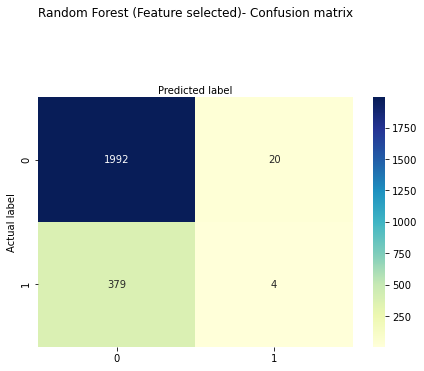

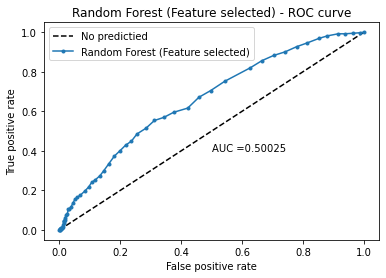

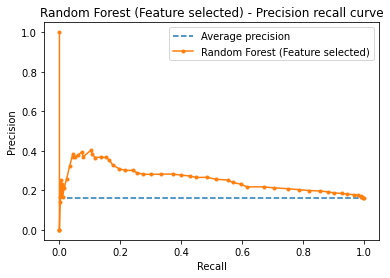

In [93]:
clf_C = RandomForestClassifier(random_state=42)
clf_C.fit(X_train_log_nw, Y_train)
final_model.append(model_train('Random Forest (Feature selected)', clf_C,X=X_test_log_nw, Y=Y_test))

### Random Forest(Improved)

 Total Time: 19.6162
--------Best Estimator--------
Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=5, n_estimators=600,
                                        random_state=42))])
 
--------Best Hyperparameters--------
{'randomforestclassifier__max_depth': 5, 'randomforestclassifier__n_estimators': 600, 'randomforestclassifier__random_state': 42}
 
====== Classification model [Random forest (improved)] =========
              precision    recall  f1-score   support

           0       0.89      0.63      0.73      2012
           1       0.23      0.60      0.33       383

    accuracy                           0.62      2395
   macro avg       0.56      0.61      0.53      2395
weighted avg       0.79      0.62      0.67      2395



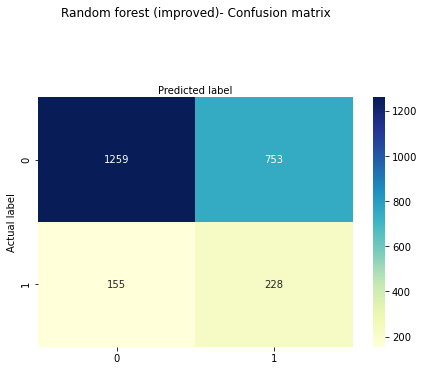

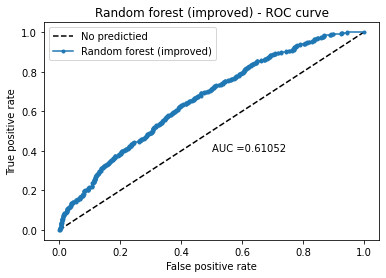

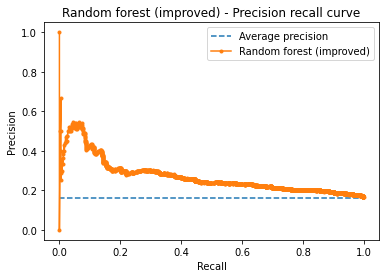

[{'Model': 'Logistic Regression (improved)',
  'Best hyperparam': {'logisticregression__C': 0.0027825594022071257,
   'logisticregression__penalty': 'l2',
   'logisticregression__random_state': 42},
  'AUC': 0.6334},
 {'Model': 'KNN (improved)',
  'Best hyperparam': {'kneighborsclassifier__n_neighbors': 95,
   'kneighborsclassifier__p': 1,
   'kneighborsclassifier__weights': 'uniform'},
  'AUC': 0.61552},
 {'Model': 'Random forest (improved)',
  'Best hyperparam': {'randomforestclassifier__max_depth': 5,
   'randomforestclassifier__n_estimators': 600,
   'randomforestclassifier__random_state': 42},
  'AUC': 0.61052}]

In [94]:
# Random forest with k-fold, GridSearchCV
n_estimators = np.linspace(600,800, num=10)

params = {
    'n_estimators': [600],    #[int(x) for x in n_estimators],
    'max_depth': [5],    #[5, 15, 20],
    'random_state': [42]
}
new_params = {'randomforestclassifier__' + key: params[key] for key in params}

pipe = make_pipeline(SMOTE(random_state=42), 
                              RandomForestClassifier(n_estimators=375, random_state=42))

rf_clf, rf = param_search('Random forest (improved)', pipe, new_params,kf)

final_model.append(model_train('Random forest (improved)', rf_clf, X=X_test_log_nw, Y=Y_test))
final_result.append(rf)
final_result

### XGBoost (Feature selected)

====== Classification model [XGBoost(Feature selected)] =========
              precision    recall  f1-score   support

           0       0.85      0.97      0.90      2012
           1       0.38      0.11      0.17       383

    accuracy                           0.83      2395
   macro avg       0.62      0.54      0.54      2395
weighted avg       0.78      0.83      0.79      2395



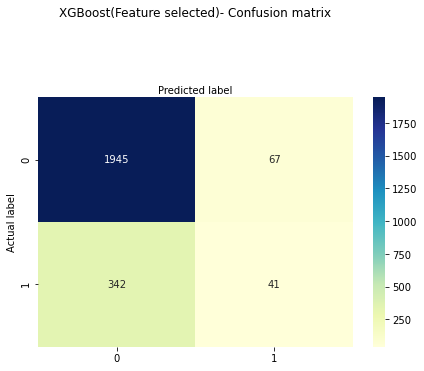

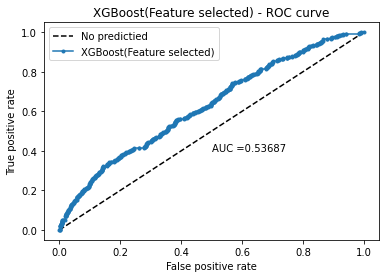

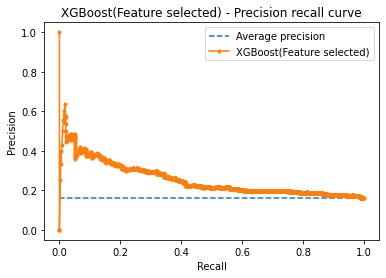

In [95]:
clf_D = XGBClassifier(random_state=42, eval_metric='logloss')
clf_D.fit(X_train_log_nw, Y_train)
final_model.append(model_train('XGBoost(Feature selected)', clf_D,X=X_test_log_nw, Y=Y_test))

### XGBoost (Improved)

 Total Time: 16.4844
--------Best Estimator--------
Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, enable_categorical=False,
                               eval_metric='logloss', gamma=0.3, gpu_id=-1,
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=7, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=900,
                               n_jobs=16, num_parallel_tree=1, predictor='auto',
                               random_state=42, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=0.5,
                               tree_met

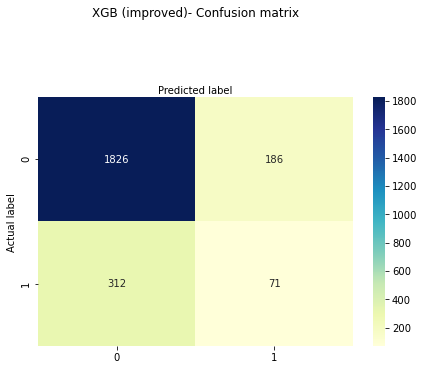

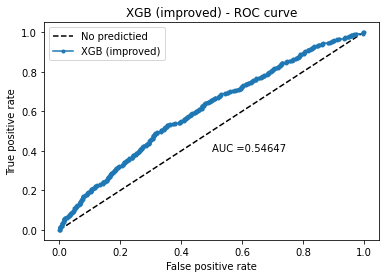

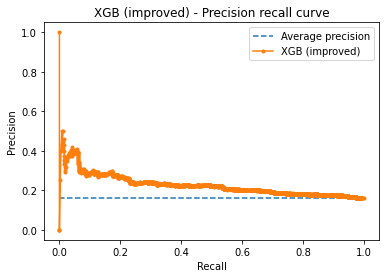

[{'Model': 'Logistic Regression (improved)',
  'Best hyperparam': {'logisticregression__C': 0.0027825594022071257,
   'logisticregression__penalty': 'l2',
   'logisticregression__random_state': 42},
  'AUC': 0.6334},
 {'Model': 'KNN (improved)',
  'Best hyperparam': {'kneighborsclassifier__n_neighbors': 95,
   'kneighborsclassifier__p': 1,
   'kneighborsclassifier__weights': 'uniform'},
  'AUC': 0.61552},
 {'Model': 'Random forest (improved)',
  'Best hyperparam': {'randomforestclassifier__max_depth': 5,
   'randomforestclassifier__n_estimators': 600,
   'randomforestclassifier__random_state': 42},
  'AUC': 0.61052},
 {'Model': 'XGB (improved)',
  'Best hyperparam': {'xgbclassifier__colsample_bytree': 0.8,
   'xgbclassifier__gamma': 0.3,
   'xgbclassifier__max_depth': 7,
   'xgbclassifier__min_child_weight': 1,
   'xgbclassifier__n_estimators': 900,
   'xgbclassifier__objective': 'binary:logistic',
   'xgbclassifier__subsample': 0.5},
  'AUC': 0.54647}]

In [96]:
# XGB with k-fold, GridSearchCV

params = {
        'n_estimators': [900],   #range(800,1000,100),
        'min_child_weight': [1],   #[1, 5],
        'gamma': [0.3],   #[0.2, 0.3],
        'subsample': [0.5],
        'colsample_bytree': [0.8],   #[0.6, 0.8, 1.0],
        'max_depth': [7],    #[4, 5, 7],
        'objective': ['binary:logistic']
        }

new_params = {'xgbclassifier__' + key: params[key] for key in params}

pipe = make_pipeline(SMOTE(random_state=42), 
                              XGBClassifier(eval_metric='logloss', random_state=42))

xgb_clf, xgb = param_search('XGB (improved)', pipe, new_params,kf)

final_model.append(model_train('XGB (improved)', xgb_clf, X=X_test_log_nw, Y=Y_test))
final_result.append(xgb)
final_result

In [97]:
final_model

[{'Model': 'Logistic regression(Feature selected)',
  'Accuracy': 0.8405,
  'Precision': 0.55556,
  'Recall': 0.01305,
  'AUC': 0.50553},
 {'Model': 'Logistic Regression (improved)',
  'Accuracy': 0.69132,
  'Precision': 0.24896,
  'Recall': 0.62663,
  'AUC': 0.6334},
 {'Model': 'KNN (Feature selected)',
  'Accuracy': 0.8263,
  'Precision': 0.33333,
  'Recall': 0.08616,
  'AUC': 0.52668},
 {'Model': 'KNN (improved)',
  'Accuracy': 0.66178,
  'Precision': 0.2226,
  'Recall': 0.6893,
  'AUC': 0.61552},
 {'Model': 'Random Forest (Feature selected)',
  'Accuracy': 0.8334,
  'Precision': 0.16667,
  'Recall': 0.01044,
  'AUC': 0.50025},
 {'Model': 'Random forest (improved)',
  'Accuracy': 0.66007,
  'Precision': 0.23242,
  'Recall': 0.5953,
  'AUC': 0.61052},
 {'Model': 'XGBoost(Feature selected)',
  'Accuracy': 0.82923,
  'Precision': 0.37963,
  'Recall': 0.10705,
  'AUC': 0.53687},
 {'Model': 'XGB (improved)',
  'Accuracy': 0.60768,
  'Precision': 0.27626,
  'Recall': 0.18538,
  'AUC': 0.5

In [98]:
final_model_df = pd.DataFrame(final_model)
final_model_df.set_index('Model', inplace=True)

In [99]:
index = ['1','2','3','4','5','6','7','8']
final_model_df['No.'] = index
final_model_df.reset_index(inplace=True)
final_model_df.set_index('No.',inplace=True)

In [100]:
final_model_df

,Model,Accuracy,Precision,Recall,AUC
No.,,,,,
1,Logistic regression(Feature selected),0.84050,0.55556,0.01305,0.50553
2,Logistic Regression (improved),0.69132,0.24896,0.62663,0.63340
3,KNN (Feature selected),0.82630,0.33333,0.08616,0.52668
4,KNN (improved),0.66178,0.22260,0.68930,0.61552
5,Random Forest (Feature selected),0.83340,0.16667,0.01044,0.50025
6,Random forest (improved),0.66007,0.23242,0.59530,0.61052
7,XGBoost(Feature selected),0.82923,0.37963,0.10705,0.53687
8,XGB (improved),0.60768,0.27626,0.18538,0.54647


In [101]:
# final_model_df.sort_values(by='AUC',ascending=False)